In [761]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
import sys, os, getpass, socket
import urllib, json
import urllib.request 
import re
from collections import Counter
username = getpass.getuser()
hostname = socket.gethostname()

sys.path.append("/home/{0}/pylig".format(username))  # my source to get the relative path, add your source

In [587]:
import numpy as np
import scipy
import re
from matplotlib.pyplot import *
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import tqdm
import pickle
import struct
import array
from scipy.sparse import csr_matrix

# Compare PDBBind (v2019) and BindingMOAD 2020
I started from the comparison of PDBBind and BindingMOAD. Downloaded both datasets from their websites.

In [667]:
from databases.bindingmoad.bindingmoad_paths import *
from databases.pdbbind.pdbbind_paths import *
from databases.db_comparison.data_utils import *
from databases.db_comparison.data_utils import UTILS  # for autoreload
from lig_prot.types_list import CPLAtomTypes

In [169]:
PATH_index, PATH_index_refined, PATH_index_detailed, PATH_pdbbind_general = get_pdbbind_paths('2019')
PATH_CCD = '/home/{0}/data/pdbe_dict/components.cif'.format(username)
PATH_main = '/home/{0}/data/combined_dataset/'.format(username)

### Parse the BindingMOAD index file
A piece of index corresponding to 10gs
```bash
,,10GS,,,,,,,
,,,MES:A:211,invalid,,,,,C1COCC[NH+]1CCS(=O)(=O)[O-],
,,,MES:B:211,invalid,,,,,C1COCC[NH+]1CCS(=O)(=O)[O-],
,,,VWW:A:210,valid,Ki,=,0.4,uM,c1ccc(cc1)CSC[C@@H](C(=O)N[C@H](c2ccccc2)C(=O)O)NC(=O)CC[C@@H](C(=O)O)N,
,,,VWW:B:210,valid,Ki,=,0.4,uM,c1ccc(cc1)CSC[C@@H](C(=O)N[C@H](c2ccccc2)C(=O)O)NC(=O)CC[C@@H](C(=O)O)N,
```
will become
```python
{'10gs': {'VWW': ('Ki', '=', 0.4, 'uM', 6.3979400086720375)}}
```

In [94]:
bindingmoad_index = {}
bindingmoad_index_detailed = {}
bindingmoad_index_invalid = {}
bindingmoad_index_p_part = {}
cur_pdbcode = ''
with open('{0}index_2020.csv'.format(PATH_bindingmoad)) as F:
    for ln_ in F:
        ln = ln_.replace('\n', '').split(',')
        if len(ln[2]) == 4:
            cur_pdbcode = ln[2].lower()
            bindingmoad_index[cur_pdbcode] = {}
            bindingmoad_index_detailed[cur_pdbcode] = {}
            bindingmoad_index_invalid[cur_pdbcode] = {}
            bindingmoad_index_p_part[cur_pdbcode] = {}
            continue
        elif ln[3] != '':
            if ln[4] == 'invalid':
                bindingmoad_index_invalid[cur_pdbcode][ln[3].split(':')[0]] = ','.join(ln)
                continue
            elif ln[4] == 'Part of Protein':
                bindingmoad_index_p_part[cur_pdbcode][ln[3].split(':')[0]] = ','.join(ln)
                continue
            elif (ln[4] == 'valid') and (ln[5] != '') and (ln[6] != '') and (ln[7] != ''):
                units_ = ln[8]  # "M", "mM", "uM", "nM", "pM", "fM", "M^-1"
                val_ = float(ln[7])
                pval_ = None
                if units_ == 'M':                    
                    pval_ = -np.log10(val_)
                    val_ = val_ * (10**(6))
                    units_ = 'uM'
                elif units_ == 'mM':                    
                    pval_ = -np.log10(val_*(10**(-3)))
                    val_ = val_ * (10**(3))
                    units_ = 'uM'
                elif units_ == 'uM':                    
                    pval_ = -np.log10(val_*(10**(-6)))
                elif units_ == 'nM':                    
                    pval_ = -np.log10(val_*(10**(-9)))
                    val_ = val_ * (10**(-3))
                    units_ = 'uM'
                elif units_ == 'pM':                    
                    pval_ = -np.log10(val_*(10**(-12)))
                    val_ = val_ * (10**(-6))
                    units_ = 'uM'
                elif units_ == 'fM':                    
                    pval_ = -np.log10(val_*(10**(-15)))
                    val_ = val_ * (10**(-9))
                    units_ = 'uM'
                elif units_ == 'M^-1':                    
                    pval_ = -np.log10(1./val_)
                else:
                    print('Unknown unit!', units_)
                ligcode,c_id,r_id = ln[3].split(':')
                r_id = int(r_id)
                bindingmoad_index[cur_pdbcode][ligcode] = tuple([ln[5].replace('ic50', 'IC50'), 
                                                                 ln[6], val_, units_, pval_])
                if ligcode not in bindingmoad_index_detailed[cur_pdbcode]:
                    bindingmoad_index_detailed[cur_pdbcode][ligcode] = []
                bindingmoad_index_detailed[cur_pdbcode][ligcode].append(tuple([c_id, r_id, 
                                                                          ln[5].replace('ic50', 'IC50'), 
                                                                          ln[6], val_, units_, pval_]))
pdbcodes_bindingmoad = sorted(bindingmoad_index.keys())

In [7]:
print('BindingMOAD index size:', len(bindingmoad_index))
# len(pdbbind_index)
for p in pdbcodes_bindingmoad[:10]:
#     for k in binding_db_index[p].keys():
#         if 'pM' in binding_db_index[p][k]:
    print(p, bindingmoad_index[p])

BindingMOAD index size: 14135
10gs {'VWW': ('Ki', '=', 0.4, 'uM', 6.3979400086720375)}
11gs {'GSH EAA': ('Ki', '=', 1.5, 'uM', 5.823908740944319)}
13gs {'SAS': ('Ki', '=', 24.0, 'uM', 4.619788758288394)}
181l {'BNZ': ('Ka', '=', 5700.0, 'M^-1', 3.7558748556724915)}
182l {'BZF': ('Ka', '=', 8900.0, 'M^-1', 3.949390006644913)}
183l {'DEN': ('Ka', '=', 5170.0, 'M^-1', 3.7134905430939424)}
184l {'I4B': ('Ka', '=', 51000.0, 'M^-1', 4.707570176097937)}
185l {'IND': ('Kd', '=', 289.0, 'uM', 3.5391021572434522)}
186l {'N4B': ('Kd', '=', 14.0, 'uM', 4.853871964321762)}
187l {'PXY': ('Kd', '=', 422.0, 'uM', 3.374687549038326)}


### Parse the PDBBind index file

Parsing the INDEX_general_PL_data.yyyy

A piece of index corresponding to 10gs
```bash
10gs  2.20  1998   6.40  Ki=0.4uM      // 10gs.pdf (VWW)
```
will become
```python
{'10gs': {'VWW': ('Ki', '=', 0.4, 'uM', 6.3979400086720375)}}
```

In [172]:
print(PATH_index)

/home/maria/data/pdbbind/2019/index/INDEX_general_PL_data.2019


In [8]:
pdbbind_index = {}
cur_pdbcode = ''
with open(PATH_index) as F:
    for ln_ in F:
        if ln_.startswith('#'):
            continue
        ln = ln_.replace('\n', '').split()
#         print(ln)
        cur_pdbcode = ln[0].lower()
        if not os.path.exists('{0}{1}'.format(PATH_pdbbind_general, cur_pdbcode)):
            continue
        pdbbind_index[cur_pdbcode] = {}
        try:
            btype, bsign, val_, units_ = re.findall(r'IC50|[A-Za-z]+|[\d\.\d]+|\W+', ln[4])
        except ValueError:
            print(cur_pdbcode, re.findall(r'IC50|[A-Za-z]+|[\d\.\d]+|\W+', ln[4]))
            break
        ligname = None
        mol_ids = []
        if '(' in ln_ and ')' in ln:
            ligname_candidate = ln_.split(')')[0].split('(')[-1]
            if ligname_candidate.isupper():
                ligname = ligname_candidate.replace('&', ' ')
        if ligname is None:
            Fmol = open('{0}{1}/{1}_ligand.mol2'.format(PATH_pdbbind_general, cur_pdbcode), 'r')
            a = Fmol.readline()
            while '@<TRIPOS>ATOM' not in a:
                a = Fmol.readline()
            a = Fmol.readline()
            while '@<TRIPOS>BOND' not in a:
                resname = a.split()[7]
                if resname not in mol_ids:
                    mol_ids.append(resname)
                a = Fmol.readline()
            Fmol.close()
            ligname = ' '.join(mol_ids)
        
        val_ = float(val_)
        pval_ = None
        if units_ == 'M':                    
            pval_ = -np.log10(val_)
            val_ = val_ * (10**(6))
            units_ = 'uM'
        elif units_ == 'mM':                    
            pval_ = -np.log10(val_*(10**(-3)))
            val_ = val_ * (10**(3))
            units_ = 'uM'
        elif units_ == 'uM':                    
            pval_ = -np.log10(val_*(10**(-6)))
        elif units_ == 'nM':                    
            pval_ = -np.log10(val_*(10**(-9)))
            val_ = val_ * (10**(-3))
            units_ = 'uM'
        elif units_ == 'pM':                    
            pval_ = -np.log10(val_*(10**(-12)))
            val_ = val_ * (10**(-6))
            units_ = 'uM'
        elif units_ == 'fM':                    
            pval_ = -np.log10(val_*(10**(-15)))
            val_ = val_ * (10**(-9))
            units_ = 'uM'
        else:
            print('Unknown unit!', units_)
        pdbbind_index[cur_pdbcode][ligname] = tuple([btype, bsign, val_, units_, pval_])
pdbcodes_pdbbind = sorted(pdbbind_index.keys())

### Read the PDBBind comments

In [9]:
pdbbind_index_w_comments = {}
print(PATH_index_detailed)

with open(PATH_index_detailed) as F:
    for ln_ in F:
        if ln_.startswith('#'):
            continue
        ln_ = ln_.replace('\n', '')
        ln = ln_.split()
        cur_pdbcode = ln[0].lower()
        comm = ln_.split('//')[1]
        if not os.path.exists('{0}{1}'.format(PATH_pdbbind_general, cur_pdbcode)):
            continue
        pdbbind_index_w_comments[cur_pdbcode] = comm

/home/maria/data/pdbbind/2019/index/INDEX_general_PL.2019


In [10]:
print('PDBBind index size:', len(pdbbind_index))
for p in pdbcodes_pdbbind[:10]:
#     for k in binding_db_index[p].keys():
#         if 'pM' in binding_db_index[p][k]:
    print(p, pdbbind_index[p], pdbbind_index_w_comments[p])

PDBBind index size: 17652
10gs {'VWW': ('Ki', '=', 0.4, 'uM', 6.3979400086720375)}  10gs.pdf (VWW)
11gs {'GSH EAA': ('Ki', '=', 1.5, 'uM', 5.823908740944319)}  11gs.pdf (2-mer) redundant to 3gss
13gs {'SAS': ('Ki', '=', 24.0, 'uM', 4.619788758288394)}  13gs.pdf (SAS)
16pk {'BIS': ('Ki', '=', 6.0, 'uM', 5.221848749616356)}  16pk.pdf (BIS) X-ray(Trypanosoma brucei PGK) while Ki(yeast PGK)
184l {'I4B': ('Kd', '=', 19.0, 'uM', 4.721246399047171)}  184l.pdf (I4B) ligand is compound 39
185l {'IND': ('Kd', '=', 290.0, 'uM', 3.537602002101044)}  185l.pdf (IND) ligand is compound 15
186l {'N4B': ('Kd', '=', 14.0, 'uM', 4.853871964321762)}  186l.pdf (N4B) ligand is compound 38
187l {'PXY': ('Kd', '=', 422.0, 'uM', 3.374687549038326)}  187l.pdf (PXY) ligand is compound 18
188l {'OXE': ('Kd', '=', 470.0, 'uM', 3.3279021420642825)}  188l.pdf (OXE) ligand is compound 4
1a07 {'ACE PTR GLU DIP': ('Kd', '=', 0.4, 'uM', 6.3979400086720375)}  1a07.pdf (4-mer) incomplete ligand structure


### Filter complexes present in both benchmarks

In [49]:
pdbcodes_both = sorted(list(set(pdbcodes_bindingmoad).intersection(set(pdbcodes_pdbbind))))
pdbcodes_both_all = sorted(list(set(pdbcodes_bindingmoad).union(set(pdbcodes_pdbbind))))

### Helper functions

In [12]:
# provides support for the glycans and peptides
def check_subcomponents(lig_code):
    ligcode_found = False
    data_str = ''
    with open(PATH_CCD) as F_ccd:
        for ln_ in F_ccd:
            if ligcode_found and ln_.startswith('_chem_comp.pdbx_subcomponent_list'):
                if '"' in ln_:
                    components = ln_.split('"')[1].split('"')[0]
                    return components
                else:
                    return None
            if ln_.startswith('data_' + lig_code):
                data_str = ln_
                ligcode_found = True       
    return None

In [13]:
# example
print(check_subcomponents('SUC'))

GLC FRU


### Check whether the complexes with same PDB ids are same

In [13]:
problem_type_dct = {'sign': [], 'other': [], 'differentK': [], 'differentK+sign': [], 
                    'pdbbind_MOL': [], 'pdbbind_NON': [], 'pdbbind_UNK': [], 'pdbbind_LIG': [], 'pdbbind_DEL': [],
                   'small_resname_diff': [], 'different_lig_codes': [], 'almost_equal': []}
# subcomponents cache
components_dict = {}
# relative difference thresholds
relative_tols = [2, 5, 10, 50, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
n_problems = 0

relative_differences = []
different_bks = []


def inner_tuples_compare(pdbcode, t1, t2):
    '''
    Helper function that compares tuples associated with each pdbcode.
    '''
    if t1 == t2:
        return 'equal'
    elif t1[3] == 'M^-1' and np.isclose(t1[4], t2[4], atol=10e-4):
        return 'equal'
    elif t1[3] == 'M^-1' and np.isclose(t1[4], t2[4], atol=10e-2):
        return 'almost_equal'
    elif (t1[1:] == t2[1:]) and (set([t1[0], t2[0]]) in [set(['Ki', 'Kd']), set(['Ki', 'IC50']), set(['Kd', 'IC50'])]):
        return 'differentK'
    elif (t1[2:] == t2[2:]) and (t1[0] == t2[0]) and (t1[1] != t2[1]):
        return 'sign'
    elif (set([t1[0], t2[0]]) in [set(['Ki', 'Kd']), set(['Ki', 'IC50']), set(['Kd', 'IC50'])]) and (t1[1] != t2[1]) and (t1[2:] == t2[2:]):
        return 'differentK+sign'
    elif t1[0] == t2[0] and np.isclose(t1[4], t2[4], atol=10e-2):
        return 'almost_equal'
    elif (t1[:2] == t2[:2]):
        if t1[3] == 'M^-1':
            diff_relative = max(1./t1[2], t2[2])/min(1./t1[2], t2[2])
        else:
            diff_relative = max(t1[2], t2[2])/min(t1[2], t2[2])
        diff_relative_lg = max(t1[4], t2[4])/min(t1[4], t2[4])
        for rt in relative_tols:
            if diff_relative <= rt:
                relative_differences.append(diff_relative_lg)
                different_bks.append([t1[4], t2[4]])
                problem_name = 'max/min < {0}'.format(rt)
                if problem_name not in problem_type_dct.keys():
                    problem_type_dct[problem_name] = []  # atoms will be added in the main loop
                return problem_name
        print(pdbcode, rt, t1, t2, diff_relative)
        return 'other'
    elif (t1[:2] != t2[:2]):
        if t1[3] == 'M^-1':
            diff_relative = max(1./t1[2], t2[2])/min(1./t1[2], t2[2])
        else:
            diff_relative = max(t1[2], t2[2])/min(t1[2], t2[2])
        diff_relative_lg = max(t1[4], t2[4])/min(t1[4], t2[4])
        for rt in relative_tols:
            if diff_relative <= rt:
                relative_differences.append(diff_relative_lg)
                different_bks.append([t1[4], t2[4]])
                problem_name = 'differentK+max/min < {0}'.format(rt)
                if problem_name not in problem_type_dct.keys():
                    problem_type_dct[problem_name] = []  # items will be added in the main loop
                return problem_name
        print(pdbcode, rt, t1, t2, diff_relative)
        return 'other'
    else:
        return 'other'

# main loop
n_bad = 0
for i_pdbcode, pdbcode in enumerate(pdbcodes_both):
    if i_pdbcode % 1000 == 0:
        print(i_pdbcode)
    had_small_difference = False
    # Take the first ligand from the pdbcode's ligands, based on PDBBind ID.
    # There is only ONE ligand in PDBBind (but it can be a string with several
    # residue codes). Therefore we take [0].
    k_pdbbind = list(pdbbind_index[pdbcode].keys())[0]
    
    if k_pdbbind not in bindingmoad_index[pdbcode].keys() and len(k_pdbbind) == 3 \
       and k_pdbbind not in ['MOL', 'UNK', 'NON', 'LIG', 'DEL']:
        if k_pdbbind not in components_dict:
            sbc = check_subcomponents(k_pdbbind)
            components_dict[k_pdbbind] = sbc
        else:
            sbc = components_dict[k_pdbbind]
        if sbc is not None:
            pdbbind_index[pdbcode][sbc] = pdbbind_index[pdbcode][k_pdbbind]
            del pdbbind_index[pdbcode][k_pdbbind]
            
    k_pdbbind = list(pdbbind_index[pdbcode].keys())[0]
            
    if k_pdbbind not in bindingmoad_index[pdbcode].keys():
        # Check whether the ligand ID in PDBBind and in BindingMOAD are the same, 
        # but with a permutation: 'lID1 lID2 lID3' and 'lID2 lID3 lID1'.
        # In this case we consider them to be the same and change the key in BMOAD.
        cur_keys_bmd = list(bindingmoad_index[pdbcode].keys())
        for k_bmd in cur_keys_bmd:
            if set(k_bmd.split()) == set(k_pdbbind.split()):
                bindingmoad_index[pdbcode][k_pdbbind] = bindingmoad_index[pdbcode][k_bmd]
                had_small_difference = True
    
    # Checking once again after the previous step
    if k_pdbbind in bindingmoad_index[pdbcode].keys():
        t1 = bindingmoad_index[pdbcode][k_pdbbind]
        t2 = pdbbind_index[pdbcode][k_pdbbind]
        tuple_compared = inner_tuples_compare(pdbcode, t1, t2)
        if tuple_compared == 'equal' and not had_small_difference:
            continue
        elif tuple_compared == 'equal' and had_small_difference:
            problem_type_dct['small_resname_diff'].append(pdbcode)
            continue
        elif tuple_compared != 'other':
            if 'max/min' in tuple_compared:
                n_bad += 1
            problem_type_dct[tuple_compared].append(pdbcode)
            continue
    else:
        t2 = pdbbind_index[pdbcode][k_pdbbind]
        cur_keys_bmd = list(bindingmoad_index[pdbcode].keys())
        conti = False
        # find a molecule with a similar ligand name
        for k_bmd in cur_keys_bmd:
            t1 = bindingmoad_index[pdbcode][k_bmd]
            if k_pdbbind in ['MOL', 'UNK', 'NON', 'LIG', 'DEL']:
                tuple_compared = inner_tuples_compare(pdbcode, t1, t2)
                if tuple_compared in ['equal', 'almost_equal', 'sign', 'differentK', 'differentK+sign']:
                    problem_type_dct['pdbbind_' + k_pdbbind].append(pdbcode)
                    conti = True
                    break
                elif 'max/min' in tuple_compared:
                    problem_type_dct[tuple_compared].append(pdbcode)
                    n_bad += 1
                    conti = True
                    break
                else:
                    print('Unknown problem in unkown resi!', pdbcode, k_pdbbind, k_bmd)
            elif len(set(k_pdbbind.split()).intersection(set(k_bmd.split()))) > 0:
                tuple_compared = inner_tuples_compare(pdbcode, t1, t2)
                if tuple_compared in ['equal', 'almost_equal', 'sign', 'differentK', 'differentK+sign']:
                    problem_type_dct['small_resname_diff'].append(pdbcode)
                    conti = True
                    break
                elif 'max/min' in tuple_compared:
                    problem_type_dct[tuple_compared].append(pdbcode)
                    n_bad += 1
                    conti = True
                    break
                else:
                    print('Unknown problem in intersecting resi!', pdbcode, k_pdbbind, k_bmd)
            else:
                tuple_compared = inner_tuples_compare(pdbcode, t1, t2)
                if tuple_compared in ['equal', 'almost_equal', 'sign', 'differentK', 'differentK+sign']:
#                     if tuple_compared == 'equal':
                    problem_type_dct['different_lig_codes'].append(pdbcode)
#                     else:
#                         problem_type_dct[tuple_compared] += 1
                    conti = True
                    break
                elif 'max/min' in tuple_compared:
                    problem_type_dct[tuple_compared].append(pdbcode)
                    n_bad += 1
                    conti = True
                    break
                    
        if conti:
            continue
            
#     print(pdbcode)
#     print(pdbbind_index[pdbcode])
#     print(bindingmoad_index[pdbcode])
    problem_type_dct['other'].append(pdbcode)

for k in sorted(problem_type_dct.keys()):
    print(k, len(problem_type_dct[k]))
print('Total:', len(pdbcodes_both))
print(n_bad, len(relative_differences), len(different_bks))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
almost_equal 384
differentK 154
differentK+max/min < 10 55
differentK+max/min < 100 11
differentK+max/min < 1000 34
differentK+max/min < 10000 12
differentK+max/min < 100000 2
differentK+max/min < 1000000 2
differentK+max/min < 100000000 5
differentK+max/min < 2 201
differentK+max/min < 5 176
differentK+max/min < 50 59
differentK+sign 8
different_lig_codes 37
max/min < 10 98
max/min < 100 38
max/min < 1000 54
max/min < 10000 23
max/min < 100000 5
max/min < 100000000 1
max/min < 2 188
max/min < 5 169
max/min < 50 120
other 3
pdbbind_DEL 0
pdbbind_LIG 0
pdbbind_MOL 17
pdbbind_NON 92
pdbbind_UNK 0
sign 112
small_resname_diff 405
Total: 9949
1253 1253 1253


### Summary of differences 

In [14]:
tols_small = [2, 5, 10]
tols_med = [50, 100]
tols_big = [1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000]
n_problems = {'weak_difference': 0, 'incomparable': 0,
              'small_difference_bk': 0, 'medium_difference_bk': 0,
              'big_difference_bk': 0
             }
problem_types_final_dct = {}
problem_types_final_dct['weak_difference'] = ['almost_equal', 'differentK', 'sign', 'differentK+sign',
                                              'small_resname_diff', 'different_lig_codes',
                                              'pdbbind_NON', 'pdbbind_MOL'  ]

problem_types_final_dct['incomparable'] = ['other'  ]

problem_types_final_dct['small_difference_bk'] = ['differentK+max/min < ' + str(e) for e in tols_small] + \
                                                ['max/min < ' + str(e) for e in tols_small]

problem_types_final_dct['medium_difference_bk'] = ['differentK+max/min < ' + str(e) for e in tols_med] + \
                                                ['max/min < ' + str(e) for e in tols_med]

problem_types_final_dct['big_difference_bk'] = ['differentK+max/min < ' + str(e) for e in tols_big] + \
                                                ['max/min < ' + str(e) for e in tols_big]
for p, v in problem_types_final_dct.items():
    for k in v:
        if k in problem_type_dct.keys():
            n_problems[p] += len(problem_type_dct[k])
    
print(n_problems)
print(n_problems['small_difference_bk'] + n_problems['medium_difference_bk'] + n_problems['big_difference_bk'])

{'weak_difference': 1209, 'incomparable': 3, 'small_difference_bk': 887, 'medium_difference_bk': 228, 'big_difference_bk': 138}
1253


### Check specific differences

In [775]:
for pdbcode in problem_type_dct['different_lig_codes']:
    print(pdbcode)
    print(pdbbind_index[pdbcode])
    print(pdbbind_index_w_comments[pdbcode])
    print(bindingmoad_index[pdbcode])
    print('')

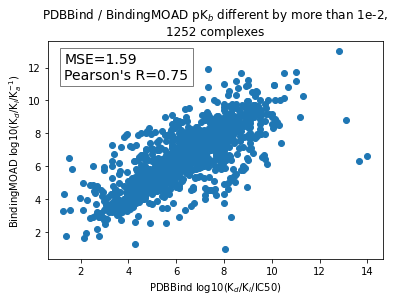

In [65]:
different_bks = np.array(different_bks)
scatter(different_bks[:, 0], different_bks[:, 1])
xlabel('PDBBind log10(K$_{d}$/K$_{i}$/IC50)')
ylabel('BindingMOAD log10(K$_{d}$/K$_{i}$/K$_a^{-1}$)')

title('PDBBind / BindingMOAD pK$_b$ different by more than 1e-2,\n{0} complexes'.format(len(different_bks)))


mse_ = mean_squared_error(different_bks[:, 0], different_bks[:, 1])
pearsonr_ = pearsonr(different_bks[:, 0], different_bks[:, 1])

# these are matplotlib.patch.Patch properties
props = dict(facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
text(0.05, 0.95, 'MSE={0:1.2f}\nPearson\'s R={1:1.2f}'.format(mse_, pearsonr_[0]), transform=gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

savefig('/home/maria/Pictures/pdbbind-bindingmoad-different.png', dpi=600)

In [762]:
# Simple check for cofactors
for pdbcode in pdbcodes_both:
    pdbcode_cur = list(pdbbind_index[pdbcode].keys())[0]
    if len(bindingmoad_index[pdbcode]) > 1:
        has_cofactor = False
        for k in bindingmoad_index[pdbcode].keys():
            if k in ['NAD', 'NDH', 'NDP', 'ATP', 'GDP', 'GTP', 'ADP', 
                     'FMN', 'FAD', 'PLP', 'TTP', 'SAM', 'GSH', 'FMT', 
                     'UDP', 'UTP']:
                has_cofactor = True
        if has_cofactor:
            print (pdbcode, pdbbind_index[pdbcode], bindingmoad_index[pdbcode])

1a4r {'GNH': ('Kd', '=', 0.22, 'uM', 6.657577319177793)} {'GDP': ('Kd', '=', 9.4e-06, 'uM', 11.0268721464003), 'GNH': ('Kd', '=', 0.22, 'uM', 6.657577319177793)}
1gwv {'NON': ('Kd', '=', 2680.0, 'uM', 2.571865205971211)} {'UDP': ('Kd', '=', 53.0, 'uM', 4.275724130399211), 'BGC GAL': ('Kd', '=', 2680.0, 'uM', 2.571865205971211)}
1gx4 {'UDP': ('Kd', '=', 53.0, 'uM', 4.275724130399211)} {'UDP': ('Kd', '=', 53.0, 'uM', 4.275724130399211), 'NAG GAL': ('Kd', '=', 580.0, 'uM', 3.2365720064370627)}
2imd {'GSH': ('Kd', '=', 0.005, 'uM', 8.301029995663981)} {'2C2': ('Kd', '=', 19.0, 'uM', 4.721246399047171), 'GSH': ('Kd', '=', 14.0, 'uM', 4.853871964321762), 'TOH': ('Ki', '=', 136.0, 'uM', 3.8664610916297826)}
3efs {'ATP': ('Kd', '=', 4.6, 'uM', 5.337242168318426)} {'ATP': ('Kd', '=', 7.2, 'uM', 5.142667503568732), 'BTN': ('Kd', '=', 3.5, 'uM', 5.455931955649724)}
6g6y {'EOK': ('Kd', '=', 0.22, 'uM', 6.657577319177793)} {'ADP': ('IC50', '=', 0.74, 'uM', 6.130768280269024), 'EOK': ('IC50', '=', 0

# Download the cofactor dictionary
Here I take the list of cofactors deposited in PDBe-KB.

In [763]:
data = UTILS.json_from_url("https://www.ebi.ac.uk/pdbe/api/pdb/compound/cofactors")

In [764]:
cofactors_list = []
cofactors_dict = {}
for k in data.keys():
    cf = data[k][0]['cofactors']
    if cf[0] is not None:
        cofactors_list += cf
        print(k, cf)
        cofactors_dict[k] = cf

Ascorbic acid ['ASC']
Factor F430 ['F43', 'M43']
MIO ['MDO']
Phosphopantetheine ['PNS']
Nicotinamide-adenine dinucleotide ['0WD', '1DG', '3AA', '3CD', '5J8', '6V0', '80F', '8ID', 'A3D', 'AP0', 'CNA', 'CND', 'DG1', 'DN4', 'DND', 'DQV', 'EAD', 'ENA', 'LNC', 'N01', 'NA0', 'NAD', 'NAE', 'NAI', 'NAJ', 'NAP', 'NAQ', 'NAX', 'NBD', 'NBP', 'NDA', 'NDC', 'NDE', 'NDO', 'NDP', 'NHD', 'NHO', 'NJP', 'NPW', 'ODP', 'P1H', 'PAD', 'SAD', 'SAE', 'SND', 'TAD', 'TAP', 'TDT', 'TXD', 'TXE', 'TXP', 'ZID']
Dipyrromethane ['18W', '29P', 'DPM']
Molybdopterin ['2MD', 'MCN', 'MGD', 'MSS', 'MTE', 'MTQ', 'MTV', 'PCD', 'PGD', 'XAX']
Adenosylcobalamin ['B12', 'B1M', 'CNC', 'COB', 'COY']
Flavin adenine dinucleotide ['6FA', 'FA8', 'FAA', 'FAB', 'FAD', 'FAE', 'FAO', 'FAS', 'FCG', 'FDA', 'FED', 'FNK', 'FSH', 'P5F', 'RFL', 'SFD']
Tetrahydrofolic acid ['1YJ', 'C2F', 'DHF', 'FFO', 'FOL', 'FON', 'FOZ', 'THF', 'THG', 'THH']
Coenzyme A ['01A', '01K', '0ET', '1C4', '1CV', '1CZ', '1HA', '1VU', '1XE', '2CP', '2NE', '3CP', '3H9', '

In [ ]:
F = open('{0}/cofactor_ids.txt'.format(PATH_main), 'w')
for cf in sorted(cofactors_list):
    F.write('{0}\n'.format(cf))
F.close()

In [47]:
# check the presense of cofactors in bindingmoad (only if there are > 1 ligands in the complex)
for pdbcode in pdbcodes_bindingmoad:
    if len(bindingmoad_index[pdbcode]) > 1:
        has_cofactor = False
        for k in bindingmoad_index[pdbcode].keys():
            if k in cofactors_list:
                has_cofactor = True
        if has_cofactor:
            print (pdbcode, bindingmoad_index[pdbcode])

1l5r {'700': ('IC50', '=', 0.145, 'uM', 6.838631997765025), 'RBF': ('Kd', '=', 17.0, 'uM', 4.769551078621726)}
1swk {'BTN': ('Ka', '~', 1000000000000.0, 'M^-1', 12.0), 'BTQ': ('Ka', '~', 1000000000000.0, 'M^-1', 12.0)}
1swp {'BTN': ('Ka', '=', 100000000.0, 'M^-1', 8.0), 'BTQ': ('Ka', '=', 100000000.0, 'M^-1', 8.0)}
1u7t {'NAD': ('Ki', '=', 425.0, 'uM', 3.3716110699496884), 'TDT': ('IC50', '=', 0.092, 'uM', 7.036212172654444)}
2du8 {'BEZ': ('Ki', '=', 7.0, 'uM', 5.154901959985743), 'FAD': ('Kd', '=', 8.0, 'uM', 5.096910013008056)}
2f01 {'BTN': ('Kd', '~', 1e-07, 'uM', 13.0), 'BTQ': ('Kd', '~', 1e-07, 'uM', 13.0)}
2gh7 {'BTN': ('Kd', '~', 1e-07, 'uM', 13.0), 'BTQ': ('Kd', '~', 1e-07, 'uM', 13.0)}
2imd {'2C2': ('Kd', '=', 19.0, 'uM', 4.721246399047171), 'GSH': ('Kd', '=', 14.0, 'uM', 4.853871964321762), 'TOH': ('Ki', '=', 136.0, 'uM', 3.8664610916297826)}
2ime {'2C2': ('Kd', '=', 19.0, 'uM', 4.721246399047171), 'GSH': ('Kd', '=', 14.0, 'uM', 4.853871964321762), 'TOH': ('Ki', '=', 136.0, '

# Create a join structure-only dataset from PDBBind and BindingMOAD

- by definition of PDBBind and Binding MOAD, resolution and R-factor are already OK.

What we want here:

- good rscc
- no Mogul bond length outliers
- PDBBind has priority
- for multichain assemblies in BindingMOAD, download them from PDBe

To use validation reports, I downloaded all of them in advance (see `new_dataset_routines.py`).

In [88]:
bad_rsccs = []
bad_outliers = []

#### Also see bad_bm2 below after cf and modres sections!!!

In [767]:
# this is an array that I manually filled after encountering some problematic complexes
bad_bm = ['1v97', '4zhh', '5gza',
          # these are bad because of chain/seq name...
         '6udy', '6udx', '6u6w', '6u5m', '6ten', '6tel', '6sgf', '6sfc', '6rt6', '6rqk', '6rfw', '6r7d', '6qxg', '6qmr', '6qdx', '6q9y', '6q9s', '6q3z', '6pu7', '6pu3', '6prg', '6pre', '6pic', '6pia', '6pi5', '6pi1', '6pgu', '6pg8', '6pg3', '6peb', '6ow7', '6oqc', '6oo6', '6onr', '6ong', '6ofq', '6od6', '6o95', '6o94', '6o8u', '6o6f', '6nyh', '6nw3', '6nv7', '6npv', '6nor', '6nne', '6nmb', '6n7a', '6n19', '6n17', '6n0p', '6mxb', '6mtu', '6msc', '6mlj', '6mh7', '6mh1', '6mdc', '6mdb', '6md8', '6jtc', '6jn6', '6jcl', '6j3p', '6j3o', '6iyk', '6itj', '6im4', '6i0z', '6hzv', '6hwo', '6hk3', '6hdu', '6haj', '6h4x', '6h4v', '6h4t', '6h4s', '6h4q', '6h4p', '6h4o', '6h1t', '6gwe', '6gvx', '6gtz', '6gty', '6gno', '6gj5', '6ghv', '6g5q', '6g2s', '6g2r', '6f8n', '6exq', '6ex8', '6e3g', '6e23', '6e22', '6e1y', '6dzx', '6dyu', '6dmf', '6djd', '6die', '6dha', '6dd1', '6dd0', '6d49', '6d3q', '6bgc', '6b0z', '6av6', '6agt', '6a8n', '5zg0', '5zcu', '5z75', '5z2l', '5ysf', '5ysd', '5yj1', '5yj0', '5yd5', '5yd4', '5yd3', '5ybg', '5ybf', '5yak', '5y8t', '5xfv', '5x80', '5x66', '5x5m', '5x5d', '5wkc', '5w3y', '5vl0', '5utq', '5utp', '5uoc', '5uo8', '5uf4', '5uf1', '5u8w', '5u8v', '5u8u', '5u1q', '5u06', '5tz1', '5tyi', '5tf9', '5tdc', '5t5j', '5swb', '5osx', '5od2', '5o6h', '5ncf', '5mzk', '5mtp', '5mt9', '5mt3', '5mam', '5m3z', '5lq1', '5ldq', '5k7g', '5j5i', '5j5g', '5j5f', '5ixe', '5iki', '5i7a', '5i3k', '5hjg', '5gzk', '5gwe', '5gie', '5g4r', '5fv9', '5fu3', '5fre', '5fp3', '5fjn', '5fa6', '5ek3', '5e58', '5dvi', '5duv', '5d40', '5d3u', '5cty', '5ctx', '5chr', '5chq', '5c8w', '5c79', '5c6c', '5c03', '5bxs', '5adv', '5ab7', '4zze', '4zs4', '4zhc', '4zb9', '4z76', '4yvx', '4ym1', '4ylz', '4yhi', '4y14', '4xwy', '4xrz', '4xry', '4wqq', '4w5i', '4ur9', '4up4', '4uhl', '4rut', '4r6n', '4r57', '4r08', '4qzu', '4qzt', '4qyn', '4qsj', '4q9n', '4pfy', '4p8p', '4p8m', '4p8c', '4otj', '4ooe', '4oit', '4nz2', '4n9i', '4mxo', '4m11', '4l77', '4l6g', '4kew', '4k9w', '4k4b', '4k4a', '4jvr', '4jvn', '4jvm', '4jor', '4j36', '4isk', '4ijv', '4hwk', '4hog', '4hoe', '4h97', '4gh8', '4ego', '4du2', '4dbw', '4d4c', '4d45', '4d43', '4d42', '4d41', '4cq8', '4co1', '4co0', '4cfn', '4c7k', '4c7j', '4buy', '4bux', '4buw', '4buv', '4but', '4bus', '4bui', '4buf', '4bu9', '4bu8', '4bu6', '4btj', '4bqp', '4bqo', '4bnn', '4bnl', '4bnj', '4bng', '4al9', '4a3r', '3zk5', '3u4s', '3td3', '3lex', '3g1r', '3en6', '3aj6', '2zhl', '2z93', '2yoo', '2xon', '2xnv', '2wt2', '2wr9', '2wpf', '2wpe', '2wp6', '2wdb', '2w1u', '2fs4', '2fav', '2cjp', '2cb8', '1zhs', '1z8a', '1y7l', '1w9o', '1lax', '1f06'
         ]
multilig_bm = []
bad_rsccs_bm = []
bad_outliers_bm = []
pdbcodes_ligcodes_bm_not_pb_good = []

for pdbcode in pdbcodes_both_all:
    if pdbcode in pdbcodes_pdbbind:
        cur_lig = pdbbind_index[pdbcode]
#         cur_rscc = []
#         val_info = []
#         ks = list(cur_lig.keys())
#         for ligcode in ks[0].split():
#             rscc_cur = UTILS.get_rscc_from_validation_info(pdbcode, ligcode, '', '', '', True, True, True)
#             if rscc_cur is not None and rscc_cur != 'no density':
#                 cur_rscc.append(rscc_cur)
#             val_info_ = UTILS.get_outliers_validation_info(pdbcode, ligcode, '', '', '', 15., True, True, True)
#             if val_info is not None and val_info_ != {}:
#                 val_info.append(val_info_)
#         if cur_rscc != []:
#             if np.mean(cur_rscc) < 0.8:
#                 print(pdbcode, ks[0], np.mean(cur_rscc))
#                 bad_rsccs.append(pdbcode)
#                 continue
#         if val_info != []:
#             print(pdbcode, ks[0], val_info)
#             bad_outliers.append(pdbcode)
    else:
        if pdbcode in bad_bm:
            continue
        if len(bindingmoad_index_detailed[pdbcode]) > 1:
            multilig_bm.append(pdbcode)
            continue
        for ks in bindingmoad_index_detailed[pdbcode]:
            cur_lig = bindingmoad_index_detailed[pdbcode][ks][0]
            c_id, r_id = cur_lig[0], cur_lig[1]
            cur_rscc = []
            val_info = []
            for ligcode in ks.split():
                rscc_cur = UTILS.get_rscc_from_validation_info(pdbcode, ligcode, c_id, '', r_id, False, True, False)
                if rscc_cur is not None and rscc_cur != 'no density':
                    cur_rscc.append(rscc_cur)
                val_info_ = UTILS.get_outliers_validation_info(pdbcode, ligcode, c_id, '', r_id, 15., False, True, False)
                if val_info is not None and val_info_ != {}:
                    val_info.append(val_info_)
                r_id += 1
            c_id, r_id = cur_lig[0], cur_lig[1]
            if cur_rscc != []:
                if np.min(cur_rscc) < 0.8:
                    print(pdbcode, ks, np.min(cur_rscc), np.mean(cur_rscc))  # , cur_lig)
                    bad_rsccs_bm.append(pdbcode)
                    continue
            if val_info != []:
                print(pdbcode, ks, val_info)
                bad_outliers_bm.append(pdbcode)
            pdbcodes_ligcodes_bm_not_pb_good.append([pdbcode, len(ks.split()), ks, c_id, r_id])

print(len(bad_rsccs), len(bad_outliers))
print(len(bad_rsccs_bm), len(bad_outliers_bm))

In [695]:
joint_bad = bad_rsccs + bad_outliers + bad_rsccs_bm + bad_outliers_bm + bad_bm + multilig_bm
ok_pb_bm_joint_pdbcodes = []
for pdbcode in pdbcodes_both_all:
    if pdbcode not in joint_bad:
        ok_pb_bm_joint_pdbcodes.append(pdbcode)

print(len(ok_pb_bm_joint_pdbcodes))

19717


In [690]:
print([len(e) for e in [bad_rsccs + bad_outliers + bad_rsccs_bm + bad_outliers_bm, bad_bm, multilig_bm]])

[1714, 325, 82]


In [144]:
pdbcodes_pb_good = []
pdbcodes_bm_not_pb_good = []
for pdbcode in pdbcodes_both_all:
    if pdbcode in pdbcodes_pdbbind:
        if pdbcode not in bad_rsccs and pdbcode not in bad_outliers:
            pdbcodes_pb_good.append(pdbcode)
    else:
        if pdbcode not in bad_rsccs_bm and pdbcode not in bad_outliers_bm and pdbcode not in bad_bm \
            and pdbcode not in multilig_bm:
            pdbcodes_bm_not_pb_good.append(pdbcode)
print(len(pdbcodes_pb_good), len(pdbcodes_bm_not_pb_good))
UTILS.write_ids(pdbcodes_pb_good, '{0}pdbcodes_pb_good.txt'.format(PATH_main))
UTILS.write_ids(pdbcodes_bm_not_pb_good, '{0}pdbcodes_bm_not_pb_good.txt'.format(PATH_main))
UTILS.write_ids([' '.join([str(e) for e in ele]) for ele in pdbcodes_ligcodes_bm_not_pb_good],
                '{0}pdbcodes_ligcodes_bm_not_pb_good.txt'.format(PATH_main))

16330 3387


In [145]:
UTILS.write_ids(pdbcodes_bindingmoad, '{0}pdbcodes_bindingmoad.txt'.format(PATH_main))

Later we'll remove the PDBBind Core

In [577]:
casf_2013 = UTILS.read_ids('{0}casf_2013_codes.dat'.format(PATH_data))
casf_2016 = UTILS.read_ids('{0}casf_2016_codes.dat'.format(PATH_data))
print(len(set(pdbcodes_pb_good).intersection(set(casf_2013))))
print(len(set(pdbcodes_pb_good).intersection(set(casf_2016))))


184
269


# Dataset from PDB with cofactors and modified residues

### Helpers
read the information from intermediate files that we generate in this notebook

In [27]:
def get_complex_info():
    """
    Parse the precomputed information on complex' cofactors, ligands and their quality.
    :return:
    """
    lig_info = {}

    with open('/home/maria/data/combined_dataset/lig_info.txt') as F:
        for ln_ in F:
            ln = ln_.replace('\n', '').replace('no density', 'no_density').split()
            pdbcode, ligcode, c_id, sa_id, res_id, is_carb, rscc_cur = ln
            if pdbcode not in lig_info.keys():
                lig_info[pdbcode] = {}
            if rscc_cur == 'None':
                rscc_cur = None
            elif rscc_cur != 'no_density':
                rscc_cur = float(rscc_cur)

            lig_info[pdbcode][(ligcode, c_id, sa_id, int(res_id))] = [ligcode, c_id, sa_id, int(res_id), bool(is_carb), rscc_cur]

    no_density = UTILS.read_counter('/home/maria/data/combined_dataset/no_density.txt')
    ok_rscc = UTILS.read_counter('/home/maria/data/combined_dataset/ok_rscc.txt')

    return sorted(lig_info.keys()), lig_info, ok_rscc, no_density


def get_complex_info_mr():
    """
    Parse the precomputed information on complex' modified residues, ligands and their quality.
    :return:
    """
    lig_info = {}
    mr_info = {}

    with open('/home/maria/data/combined_dataset/lig_info_mr.txt') as F:
        for ln_ in F:
            ln = ln_.replace('\n', '').replace('no density', 'no_density').split()
            pdbcode, ligcode, c_id, sa_id, res_id, is_carb, rscc_cur = ln
            if pdbcode not in lig_info.keys():
                lig_info[pdbcode] = {}
            if rscc_cur == 'None':
                rscc_cur = None
            elif rscc_cur != 'no_density':
                rscc_cur = float(rscc_cur)

            lig_info[pdbcode][(ligcode, c_id, sa_id, int(res_id))] = [ligcode, c_id, sa_id, int(res_id), bool(is_carb), rscc_cur]

    no_density = UTILS.read_counter('/home/maria/data/combined_dataset/no_density_mr.txt')
    ok_rscc = UTILS.read_counter('/home/maria/data/combined_dataset/ok_rscc_mr.txt')

    with open('/home/maria/data/combined_dataset/info_residues.txt') as F:
        for ln_ in F:
            ln = ln_.replace('\n', '').replace('no density', 'no_density').split()
            pdbcode, ligcode, c_id, sa_id, res_id, rscc_cur = ln
            if pdbcode not in mr_info.keys():
                mr_info[pdbcode] = {}
            if rscc_cur == 'None':
                rscc_cur = None
            elif rscc_cur != 'no_density':
                rscc_cur = float(rscc_cur)

            mr_info[pdbcode][(ligcode, c_id, sa_id, int(res_id))] = [ligcode, c_id, sa_id, int(res_id), rscc_cur]

    no_density_mr = UTILS.read_counter('/home/maria/data/combined_dataset/no_density_residues.txt')
    ok_rscc_mr = UTILS.read_counter('/home/maria/data/combined_dataset/ok_rscc_residues.txt')

    valid_keys = set(lig_info.keys()).intersection(set(mr_info.keys()))

    return sorted(list(valid_keys)), lig_info, ok_rscc, no_density, mr_info, ok_rscc_mr, no_density_mr


## Cofactors
### First of all, get a list of proteins with cofactors and at least one different non-solvent ligand
Some of these can be also excluded https://en.wikipedia.org/wiki/Good%27s_buffers.
Although in some cases they can act as functional ligands. EPE, for example.
Also, there is a dictionary created by VHELIBS. But it is mostly created for active ligands, and therefore contains not only solvents, but also cofactors and other molecules.

In [317]:
solvents = ['HOH', 'K', 'NA', 'CL', 'FES', 'FEM', 
            'O', 'OEX', 'GD', 'XE', 'MN', 'CD', 'HG', 'F3S', 'OH',
            'SO4', 'ACT', 'ACY', 'GOL', 'TRS', 'BTB', 'PG0', 'PEG', 'EDO',
            'TLA', 'GOL', 'SO4', 'EDO', 'TAR', 'ACT', 'DMS', 'ASN', 'LPD', 'IPA',
            'PGE', 'PG4', 'CMO', 'NO', '1PE', 'P6G', 'DOD', '06C', 'BME', 'FMT', 'SF4']
metals = ['CA', 'MG', 'FE', 'ZN', 'MG', 'CO', 'MO']
# OXY -- leave it as is for HEM?...
# EOH -- ethanol -- leave it as is?...

First of all, filter the complexes with
- resolution < 3
- non-ionic ligands and cofactors

In [21]:
ok_pdbs = []
mol_n_atoms = {}
lig_counts = Counter()

In [132]:
cofactors_list.index('NAP')

25

In [768]:
for cf in cofactors_list[191:]:
    get_url = 'https://www.ebi.ac.uk/pdbe/api/pdb/compound/in_pdb/{0}'.format(cf)
    resp_data = UTILS.json_from_url(get_url)
    if resp_data is None:
        continue
    pdbcodes = resp_data[cf]
    for pdbcode in pdbcodes:
        if pdbcode in ok_pdbs:  # not to waste time if we run this cell once again
            continue
        exp_info = UTILS.json_from_url('https://www.ebi.ac.uk/pdbe/api/pdb/entry/experiment/{0}'.format(pdbcode))
        if 'resolution_high' in exp_info[pdbcode][0]:
            if exp_info[pdbcode][0]['resolution_high'] is not None and exp_info[pdbcode][0]['resolution_high'] >= 3.0:
                continue
        p_ligs = UTILS.json_from_url('https://www.ebi.ac.uk/pdbe/api/pdb/entry/ligand_monomers/{0}'.format(pdbcode))
        p_ligs = p_ligs[pdbcode]
        ok_ligs = []
        for i in range(len(p_ligs)):
            lig_name = p_ligs[i]['chem_comp_id']
            if lig_name == cf:
                continue
            if 'ION' in p_ligs[i]['chem_comp_name']:
                continue
            elif lig_name in solvents:
                continue
#             if lig_name not in mol_n_atoms:
#                 lig_data = json_from_url('https://www.ebi.ac.uk/pdbe/api/pdb/compound/summary/{0}'.format(lig_name))
#                 n_atoms = len(re.sub(r'H|@|\(|\)|#|\[|\]|=|\d', '', lig_data[lig_name][0]['smiles'][0]['name']))
#                 mol_n_atoms[lig_name] = n_atoms
#             if mol_n_atoms[lig_name] < 5:
#                 print('small molecule!', lig_name)
            ok_ligs.append(p_ligs[i]['chem_comp_id'])
        ok_ligs = sorted(list(set(ok_ligs)))
        for ok_lig in ok_ligs:
            lig_counts[ok_lig] += 1
        if len(ok_ligs) > 0:
            print(cf, pdbcode, ok_ligs)
            ok_pdbs.append(pdbcode)
    print([ele for ele in sorted(lig_counts.items(), key=lambda a: -a[1]) if ele[0] not in cofactors_list][:15])

In [118]:
re.sub(r'H|@|\(|\)|#|\[|\]|=|\d', '', "c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C#@@H]([C@H](O3)CO[P@@](=O)(O)O[P@](=O)(O)OP(=O)(O)O)O)O)N")

'cncccnncnCCCCOCOPOOOPOOOPOOOOON'

In [765]:
print(len(ok_pdbs))

9567


Save information on chains and small molecules to avoid manual cif parsing

In [22]:
UTILS.write_ids(ok_pdb, '/home/maria/data/combined_dataset/cofactor_proteins_cur.txt')

### Now, get the ligand information
RSCC check based on validation reports, check whether a ligand is a polymer and etc

In [246]:
ok_rscc = Counter()
lig_info = {}
no_density = Counter()

In [769]:
for p in ok_pdbs:
    ligs_data = UTILS.json_from_url('https://www.ebi.ac.uk/pdbe/api/pdb/entry/ligand_monomers/{0}'.format(p))[p]
    for lig_entry in ligs_data:
        ligcode = lig_entry['chem_comp_id']
        c_id = lig_entry['chain_id']
        is_carb = lig_entry['carbohydrate_polymer']
        res_id = lig_entry['author_residue_number']
        sa_id = lig_entry['struct_asym_id']
        if ligcode in solvents:
            continue
        rscc_cur = UTILS.get_rscc_from_validation_info(p, ligcode, c_id, sa_id, res_id)
        if rscc_cur is None:
            print('A PROBLEM', p, lig_entry)
        else:
            if rscc_cur == 'no density':
                no_density[p] += 1
            elif rscc_cur > 0.8:
                ok_rscc[p] += 1
        if p not in lig_info.keys():
            lig_info[p] = {}
        lig_info[p][(ligcode, c_id, sa_id, res_id)] = [ligcode, c_id, sa_id, res_id, is_carb, rscc_cur]

In [203]:
len(ok_rscc)

8466

Save information about RSCCs

In [208]:
UTILS.write_sorted_dict_simple(ok_rscc, '/home/maria/data/combined_dataset/ok_rscc.txt')
UTILS.write_sorted_dict_simple(no_density, '/home/maria/data/combined_dataset/no_density.txt')

In [245]:
F = open('/home/maria/data/combined_dataset/lig_info.txt', 'w')
for k in sorted(list(lig_info.keys())):
    for kl in sorted(list(lig_info[k].keys())):
        ligcode, c_id, sa_id, res_id, is_carb, rscc_cur = lig_info[k][kl]
        F.write('{0} {1} {2} {3} {4} {5} {6}\n'.format(k, ligcode, c_id, sa_id, res_id, int(is_carb), rscc_cur))
F.close()

In [213]:
len([e for e in ok_rscc.keys() if ok_rscc[e] > 1])

8209

In [28]:
ok_rscc = UTILS.read_sorted_dict_simple('/home/maria/data/combined_dataset/ok_rscc.txt')
no_density = UTILS.read_sorted_dict_simple('/home/maria/data/combined_dataset/no_density.txt')

pdbcodes, lig_info, ok_rscc, no_density = get_complex_info()

## Modified residues

### Get a list of proteins with modified residues and at least one different non-solvent ligand

### Create a dictionary of proteins with modified residues (with & without ligands)
1) Download the list of all structures with resolution at ftp://ftp.wwpdb.org/pub/pdb/derived_data/index/resolu.idx. Filter them to remove non-protein structures.

2) Scan all structures with OK resolution --> check if they have modified residues.

In [293]:
i_ln = 0
prot_structures = set()
ok_structures = []
with open('{0}pdb_entry_type.txt'.format(PATH_main)) as F_pdb_type:
    for ln_ in F_pdb_type:
        ln = ln_.replace('\n', '').split('\t')[:2]
        if ln[1] == 'prot':
            prot_structures.add(ln[0].lower())
        
with open('{0}resolu.idx'.format(PATH_main), 'r') as F_all_pdb:
    for ln_ in F_all_pdb:
        i_ln += 1
        if i_ln < 7:
            continue
#         if i_ln % 10000 == 0:
#             print(i_ln)
        ln = ln_.replace('\n', '').replace('\t', '').split(';')
        try:
            pdbcode, resol = ln[0].lower(), float(ln[1])
        except ValueError:
            print(ln)
            continue
        if pdbcode not in prot_structures:
            continue
#         overall_data = UTILS.json_from_url('https://www.ebi.ac.uk/pdbe/api/pdb/entry/summary/{0}'.format(pdbcode))[pdbcode]
#         if overall_data[0]['number_of_entities']['polypeptide'] == 0:
#             continue
        if resol < 3.0:
            ok_structures.append(pdbcode)
print(len(ok_structures))

['1MCD', '']
['6BC9', '']
['6NTI', '']
['7A0L', '']
146806


In [312]:
UTILS.write_ids(ok_structures, '{0}all_pdb_ok_resolution.txt'.format(PATH_main))

In [306]:
# TODO check alternate_conformers!
F = open('{0}has_mod_res.txt'.format(PATH_main), 'w')
has_mod_res = {}
for i_p, p in enumerate(ok_structures[:100]):
    if i_p % 1000 == 0:
        print(i_p)
    mod_res_data = UTILS.json_from_url('https://www.ebi.ac.uk/pdbe/api/pdb/entry/modified_AA_or_NA/{0}'.format(p),
                                verbose=False)
    if mod_res_data is None:
        continue
#     print(p, mod_res_data)
    has_mod_res[p] = []
    for lig_entry in mod_res_data[p]:
        ligcode = lig_entry['chem_comp_id']
        c_id = lig_entry['chain_id']
        res_id = lig_entry['author_residue_number']
        sa_id = lig_entry['struct_asym_id']
        F.write('{0} {1} {2} {3} {4}\n'.format(p, ligcode, c_id, res_id, sa_id))
        has_mod_res[p].append([ligcode, c_id, res_id, sa_id])
        print(p, has_mod_res[p][-1])
F.close()

0
132l ['DM0', 'A', 1, 'A']
132l ['MLY', 'A', 13, 'A']
132l ['MLY', 'A', 33, 'A']
132l ['MLY', 'A', 96, 'A']
132l ['MLY', 'A', 116, 'A']
148l ['FGA', 'S', 167, 'B']
148l ['API', 'S', 169, 'B']
148l ['DAL', 'S', 170, 'B']


In [316]:
has_mod_res = {}
with open('{0}has_mod_res.txt'.format(PATH_main), 'r') as F:
    for ln_ in F:
        ln = ln_.replace('\n', '').split()
        p = ln[0]
        if p not in has_mod_res.keys():
            has_mod_res[p] = []
        has_mod_res[p].append([ln[1], ln[2], int(ln[3]), ln[4]])

In [318]:
print(len(has_mod_res.keys()))

20656


### Check whether these proteins have ligands

In [319]:
pdbcodes = sorted(list(has_mod_res.keys()))
ok_pdbs_mp = []

In [770]:
for pdbcode in pdbcodes:
    if pdbcode in ok_pdbs_mp:  # not to fill it again if we run this cell again
        continue
    p_ligs = UTILS.json_from_url('https://www.ebi.ac.uk/pdbe/api/pdb/entry/ligand_monomers/{0}'.format(pdbcode))
    p_ligs = p_ligs[pdbcode]
    ok_ligs = []
    for i in range(len(p_ligs)):
        lig_name = p_ligs[i]['chem_comp_id']
        if 'ION' in p_ligs[i]['chem_comp_name']:
            continue
        elif lig_name in solvents:
            continue
        ok_ligs.append(p_ligs[i]['chem_comp_id'])
    ok_ligs = sorted(list(set(ok_ligs)))
    for ok_lig in ok_ligs:
        lig_counts[ok_lig] += 1
    if len(ok_ligs) > 0:
        print(pdbcode, ok_ligs)
        ok_pdbs_mp.append(pdbcode)

In [321]:
UTILS.write_ids(ok_pdbs_mp, '{0}has_mod_res_lig.txt'.format(PATH_main))

In [323]:
print(len(ok_pdbs_mp))

8863


In [326]:
print(len(set(ok_pdbs).intersection(set(ok_pdbs_mp))))
print(len(set(ok_pdbs).intersection(set(pdbcodes_bindingmoad))))
print(len(set(ok_pdbs_mp).intersection(set(pdbcodes_bindingmoad))))
print(len(set(ok_pdbs).intersection(set(pdbcodes_pdbbind))))
print(len(set(ok_pdbs_mp).intersection(set(pdbcodes_pdbbind))))

1014
1848
1281
323
1593


### Get the ligand information
Similarly to what was done with cofactor-ligand complexes

In [337]:
lig_info_mp = {}
no_density_mp = Counter()
ok_rscc_mp = Counter()

In [771]:
for p in ok_pdbs_mp:
    ligs_data = UTILS.json_from_url('https://www.ebi.ac.uk/pdbe/api/pdb/entry/ligand_monomers/{0}'.format(p))[p]
    for lig_entry in ligs_data:
        ligcode = lig_entry['chem_comp_id']
        c_id = lig_entry['chain_id']
        is_carb = lig_entry['carbohydrate_polymer']
        res_id = lig_entry['author_residue_number']
        sa_id = lig_entry['struct_asym_id']
        if ligcode in solvents:
            continue
        rscc_cur = UTILS.get_rscc_from_validation_info(p, ligcode, c_id, sa_id, res_id)
        if rscc_cur is None:
            print('A PROBLEM', p, lig_entry)
        else:
            if rscc_cur == 'no density':
                no_density_mp[p] += 1
            elif rscc_cur > 0.8:
                ok_rscc_mp[p] += 1
        if p not in lig_info_mp.keys():
            lig_info_mp[p] = {}
        lig_info_mp[p][(ligcode, c_id, sa_id, res_id)] = [ligcode, c_id, sa_id, res_id, is_carb, rscc_cur]

In [341]:
print(len(lig_info_mp.keys()))
print(len(ok_pdbs_mp))
print(len(ok_rscc_mp))

8863
8863
7678


In [379]:
UTILS.write_sorted_dict_simple(ok_rscc_mp, '/home/maria/data/combined_dataset/ok_rscc_mr.txt')
UTILS.write_sorted_dict_simple(no_density_mp, '/home/maria/data/combined_dataset/no_density_mr.txt')

F = open('/home/maria/data/combined_dataset/lig_info_mr.txt', 'w')
for k in sorted(list(lig_info_mp.keys())):
    for kl in sorted(list(lig_info_mp[k].keys())):
        ligcode, c_id, sa_id, res_id, is_carb, rscc_cur = lig_info_mp[k][kl]
        F.write('{0} {1} {2} {3} {4} {5} {6}\n'.format(k, ligcode, c_id, sa_id, res_id, int(is_carb), rscc_cur))
F.close()

### Check the RSCCs of modified residues of interest
with cofactors, it was done by default, as they are also "ligands"

In [368]:
info_residues = {}
no_density_residues = Counter()
ok_rscc_residues = Counter()

In [772]:
for p in ok_pdbs_mp:
    for mod_res in has_mod_res[p]:
        ligcode, c_id, res_id, sa_id = mod_res
        rscc_cur = UTILS.get_rscc_from_validation_info(p, ligcode, c_id, sa_id, res_id)
        if rscc_cur is None:
            print('A PROBLEM', p, mod_res)
        else:
            if rscc_cur == 'no density':
                no_density_residues[p] += 1
            elif rscc_cur > 0.8:
                ok_rscc_residues[p] += 1
        if p not in info_residues.keys():
            info_residues[p] = {}
        info_residues[p][(ligcode, c_id, sa_id, res_id)] = [ligcode, c_id, sa_id, res_id, rscc_cur]

In [374]:
len(set.intersection(set(ok_rscc_residues.keys()), set(ok_rscc_mp.keys())))

7457

In [378]:
UTILS.write_sorted_dict_simple(ok_rscc_residues, '/home/maria/data/combined_dataset/ok_rscc_residues.txt')
UTILS.write_sorted_dict_simple(no_density_residues, '/home/maria/data/combined_dataset/no_density_residues.txt')

F = open('/home/maria/data/combined_dataset/info_residues.txt', 'w')
for k in sorted(list(info_residues.keys())):
    for kl in sorted(list(info_residues[k].keys())):
        ligcode, c_id, sa_id, res_id, rscc_cur = info_residues[k][kl]
        F.write('{0} {1} {2} {3} {4} {5}\n'.format(k, ligcode, c_id, sa_id, res_id, rscc_cur))
F.close()

## Analyse intersections between different parts of the dataset. Perform additional parsing

- Before this step, I downloaded all the complex structures using functions from `new_dataset_routines.py` in the form of biological assemblies (this is really arguable, but I followed PDBBind that uses assemblies).
- A good point about assemblies from PDBe is that they are in cif and have a convenient notation of "segments" with different pymol's segid. And, for example, each carbo polymer will be in a separate segi, even if it consists of scattered ligands.
- I then ran the pymol-based scripts from `pymol_check_complex_validity.py` to check the distances between cofactors/modified residues and ligands, using the assembly data. We need only the cases when they are spatially proximate. 
- In that script, I also removed peptides to get rid of polymer drugs that consist of non-standard residues, but are not usual "proteins".  
- And I also checked occupancies with the script from `pymol_extract_pl_final.py`. In fact, I checked occupancies in the very end and went back to this stage (so the code is not 100% straightworward).

In [302]:
rare_elements = ['Li', 'Be', 'Na', 'Mg', 'K', 'Ca', 'Ti', 'V', 'Cr', 'Mn', 'Fe',
                 'Ni', 'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 
                 'Pd', 'Ag', 'Cd', 'In', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 
                 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Ir', 'Pt',
                 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu',
                 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs',
                 'Mt', 'Ds', 'Rg', 'Nh', 'Fl', 'Mc', 'Lv', 'Ge', 'As', 'Sb', 'Te', 'At', 'Al']
not_rare_metalloids = ['B', 'Si']
allowed_me = ['Fe', 'Mg', 'Ca', 'Zn']
rare_elements_condi = ['Sc', 'Co', 'Cs', 'Sn', 'Os', 'Po', 'No', 'Cn']
rare_elements_up = [ele.upper() for ele in rare_elements + rare_elements_condi + not_very_rare_metalloids]

In [356]:
ligs_to_drop_additional = ['4MO', '6MO', '6SE', '9S8', 'AF3', 'ALF', 'ARS', 'ART', 'AST', 'AU', 'BF4',
                           'BO3', 'CAC', 'CAD', 'CE', 'CU1', 'CU3', 'CUM', 'CUN', 'EFK', 'FE2', 'FEO',
                           'FS2', 'FSO', 'KR', 'LI', 'MN3', 'MO', 'MOM', 'MTD', 'NFC', 'NFO', 'NFR',
                           'NFU', 'NFV', 'NI', 'OMO', 'PB', 'SFS', 'SR', 'W', 'WO4', 'YB', 'IOD']

In [773]:
# some precomputed occupancies
mr_cf_occ = {}
p = ''
with open('{0}pb19_bm20_mr_cf_v1_occupancies.txt'.format(PATH_main), 'r') as F:
    for ln_ in F:
        ln = ln_.replace('\n', '').replace(', ', ',').replace('(', '').replace(')', '')
        if len(ln) == 4:
            p = ln[:4]
            mr_cf_occ[p] = {}
        else:
            ln = ln.split()
            c_id, s_id = ln[1], ln[2]
            occ = float(ln[4])
            if ',' not in ln_:
                resn = ln[0]
                resi = int(ln[3])
                mr_cf_occ[p][(resn, c_id, s_id, resi)] = occ
            else:
                resns = ln[0].split(',')
                resis = tuple(map(int, ln[3].split(',')))
                for i in range(len(resns)):
                    mr_cf_occ[p][(resns[i], c_id, s_id, resis[i])] = occ
            
for p in mr_cf_occ:
    print(p, mr_cf_occ[p])

### 1) Prepare files with modified residues for inclusion into the final dataset.
The goal here is to separate all chains not to have duplicates, to understand whether we have multiple ligands or not (have to be trated separately in that case).

In [198]:
# read the modified residue complexes
mod_res_info ={}
with open('{0}pdb_lig_mr_pairs_noncov_dmin5.2_30resmin.csv'.format(PATH_main)) as F:
    next(F)
    for ln_ in F:
        ln = ln_.replace('\n', '').split(',')
        pdbcode, ligcode, c_id_lig, sa_id_lig, resi_lig, resn, c_id_mr, sa_id_mr, resi_mr, dist = ln
        resi_lig, resi_mr, dist = int(resi_lig), int(resi_mr), float(dist)
        if pdbcode not in mod_res_info:
            mod_res_info[pdbcode] = {}
        if sa_id_lig not in mod_res_info[pdbcode]:
            mod_res_info[pdbcode][sa_id_lig] = []
        mod_res_info[pdbcode][sa_id_lig].append((ligcode, c_id_lig, sa_id_lig, resi_lig, resn, c_id_mr, sa_id_mr, resi_mr, dist))

In [568]:
# ligcode1, c_id, sa_id, resi, ligcode2, c_id2, sa_id2, resi2, dist
# ligcode, c_id_lig, sa_id_lig, resi_lig, resn, c_id_mr, sa_id_mr, resi_mr, dist

# 1) Filtering to remove entries from different chains with different segment ids, but same
#    residue names and residue ids
mod_res_pre_filtered = {}
for pdbcode in mod_res_info:
    mod_res_pre_filtered[pdbcode] = {}
    for segi in mod_res_info[pdbcode]:
        for entry in mod_res_info[pdbcode][segi]:
            if entry[0] in cofactors_dict['Heme'] + rare_elements_up + ligs_to_drop_additional + ['UNL']:  # 'HEM':
                continue
            if entry[4] in ['CAS', 'CZ2', 'CZZ', 'CAF']:
                continue
            conti = False
            for segi2 in mod_res_pre_filtered[pdbcode]:
                for entry_existing in mod_res_pre_filtered[pdbcode][segi2]:
                    if entry[0] == entry_existing[0] \
                       and entry[4] == entry_existing[4] \
                       and entry[3] == entry_existing[3] \
                       and entry[7] == entry_existing[7]:
#                        and entry[8] == entry_existing[8] \
#                         print(entry, entry_existing)
                        conti = True
                        break
                if conti:
#                     print ('continued at', entry_existing, entry)
                    break
            if conti:
                continue
            if segi not in mod_res_pre_filtered[pdbcode]:
                mod_res_pre_filtered[pdbcode][segi] = []
            mod_res_pre_filtered[pdbcode][segi].append(entry)
    if mod_res_pre_filtered[pdbcode] == {}:
        mod_res_pre_filtered.pop(pdbcode) 
                
# 2) re-grouping by chain ID
mod_res_filtered_chain = {}
for p, e_pdbcode in mod_res_pre_filtered.items():
    mod_res_filtered_chain[p] = {}
    for segi, e_segi in e_pdbcode.items():
        for entry in e_segi:
            c_id_lig = entry[1]
            if c_id_lig not in mod_res_filtered_chain[p]:
                mod_res_filtered_chain[p][c_id_lig] = []
            mod_res_filtered_chain[p][c_id_lig].append(entry)
            
# 3) removing chain duplicates
def is_j_in_i(dat_i_, dat_j_):
    dat_i = sorted(list(dat_i_))
    dat_j = sorted(list(dat_j_))
    is_subset_ = [0 for d in dat_j]
    checked = []
    for j, d_j in enumerate(dat_j):
        for d_i in dat_i:
            if d_i in checked:
                continue
            if d_i[0] == d_j[0] and d_i[1] == d_j[1] and \
               np.isclose(d_i[2], d_j[2], atol=3e-01):
                is_subset_[j] = 1
                checked.append(d_i)
    return np.all(is_subset_)
    

for p, e_pdbcode in mod_res_filtered_chain.items():
    to_pop = []
    for c_i, e_i in e_pdbcode.items():
        if c_i in to_pop:
            continue
        dat_i = set([(e[0], e[4], np.round(e[8], 1)) for e in e_i])
        for c_j, e_j in e_pdbcode.items():
            if c_j in to_pop or c_i == c_j:
                continue
            dat_j = set([(e[0], e[4], np.round(e[8], 1)) for e in e_j])
            
            if dat_j.issubset(dat_i):
#                 if len(dat_i) > 1 or len(dat_j) > 1:
#                     print(p, dat_j, 'is_subset', dat_i)
                to_pop.append(c_j)
            elif is_j_in_i(dat_i, dat_j): 
#                 if len(dat_i) > 1 or len(dat_j) > 1:
#                     print(p, dat_i, 'found_subset', dat_j)
                to_pop.append(c_j)
    for tp in to_pop:
        mod_res_filtered_chain[p].pop(tp)
            
print(len(mod_res_filtered_chain))
    
mod_residues_filtered = Counter()
for pdbcode in mod_res_filtered_chain:
    for c_id in mod_res_filtered_chain[pdbcode]:
        for entry in mod_res_filtered_chain[pdbcode][c_id]:
            mod_residues_filtered[entry[4]] += 1
            

# 4) group by ligand
mod_res_chain_lig = {}
for p, e_pdbcode in mod_res_filtered_chain.items():
    mod_res_chain_lig[p] = {}
    for c_i, e_i in e_pdbcode.items():
        for entry in e_i:
            lig1 = tuple(entry[0:4])
            lig2 = tuple(entry[4:8])
            lig2_ = tuple(entry[4:9])
            if lig1 not in mod_res_chain_lig[p]:
                mod_res_chain_lig[p][lig1] = []
            mod_res_chain_lig[p][lig1].append(lig2)

# 5) kick those with bad occupancy and once again clean everything
to_pop = []
for p, e_p in mod_res_chain_lig.items():
    if p not in mr_cf_occ:
        continue
    to_pop_l = []
    for l, e_l in e_p.items():
        if l in mr_cf_occ[p]:
            if mr_cf_occ[p][l] <= 0.8:
                to_pop_l.append(l)
        to_pop_loc = []
        for l1 in e_l:
            if l1 in mr_cf_occ[p]:
                if mr_cf_occ[p][l1] <= 0.8:
                    to_pop_loc.append(l1)
        for l1 in set(to_pop_loc):
            e_l.remove(l1)
        if len(e_l) == 0:
            to_pop_l.append(l)
    for l in set(to_pop_l):
        e_p.pop(l)
    if len(e_p) == 0:
        to_pop.append(p)
for p in set(to_pop):
    mod_res_chain_lig.pop(p)
            
            
# 6) check things with the same segi (carb sequences, in particular)
for p, e_p in mod_res_chain_lig.items():
    by_segi = {}
    for l, e_l in e_p.items():
        if l[2] not in by_segi:
            by_segi[l[2]] = set([])
        by_segi[l[2]].add(l)
    if len(by_segi) == 0:  # check for anything not popped
        print(p, e_p)
#     elif max([len(v) for v in by_segi.values()]) > 1:
#         print(p)
#         print(e_p)
#         print(by_segi)
    for v in by_segi.values():
        if len(v) <= 1:
            continue
        new_ligname = ','.join([s[0] for s in v])
        new_lig_items = list(set([e_p[s][0] for s in v]))
        new_lig_resi = tuple(s[3] for s in v)
        for l in v:
            e_p.pop(l)
        new_lig = (new_ligname, list(v)[0][1], list(v)[0][2], new_lig_resi)
        e_p[new_lig] = new_lig_items
#         print(mod_res_chain_lig[p])

        
n_ligs = 0
for p, e_pdbcode in mod_res_chain_lig.items():
    for lig_i, ligs_j in e_pdbcode.items():
        n_ligs += 1
#         if len(ligs_j) > 1:
#             for lig_j in ligs_j:
#                 if lig_i[1] != lig_j[1]:
#                     print(p, lig_i, ligs_j)

print(len(mod_res_chain_lig))
print(n_ligs)

2207
1965
2326


In [774]:
for p in mod_res_filtered_chain:
    print(p, mod_res_filtered_chain[p])

In [289]:
print(mod_residues_filtered)

Counter({'MSE': 1663, 'KCX': 269, 'LLP': 147, 'CSO': 129, 'CSD': 99, 'HIC': 84, 'FME': 73, 'SEP': 70, 'SEC': 63, 'MEN': 54, 'CSS': 50, 'CSX': 46, 'MLY': 45, 'CME': 44, 'OCS': 44, 'MHS': 39, 'TPO': 38, 'TOX': 33, 'AGM': 31, 'GL3': 22, 'MGN': 22, 'NEP': 21, 'TYQ': 16, 'PCA': 15, 'TRQ': 14, 'SME': 14, 'SCY': 12, 'NLE': 12, 'FTR': 11, 'MHO': 9, 'MDO': 9, 'DAL': 9, 'TPQ': 8, 'QPA': 8, '4FW': 8, 'F7W': 8, 'PHD': 7, 'XCN': 7, '2LT': 7, 'SNN': 6, 'CGU': 6, 'YCM': 6, 'F2Y': 6, 'AYA': 6, 'TYY': 5, 'KST': 5, 'PSW': 5, 'LYR': 5, '3CT': 5, 'MLZ': 5, 'CMT': 4, 'LYZ': 4, 'OAS': 4, 'SMC': 4, 'ALY': 4, 'CIR': 4, 'DDZ': 4, 'DGL': 4, 'HOX': 4, 'SE7': 4, 'UOX': 4, 'DHA': 3, 'PTR': 3, 'SGB': 3, 'IYR': 3, '4AK': 3, 'PHI': 3, 'ABA': 3, 'EJA': 3, 'BXT': 3, 'MVA': 3, 'CGA': 2, 'CCS': 2, 'CXM': 2, 'DBU': 2, 'TQQ': 2, 'LED': 2, 'HYP': 2, 'KPI': 2, 'SXE': 2, '1X6': 2, 'HS8': 2, 'CSU': 2, 'DLE': 2, 'DPR': 2, 'MED': 2, 'DM0': 2, 'YOF': 2, 'SNC': 2, 'SAR': 2, 'JLP': 2, 'F6N': 2, 'KKD': 2, '0A9': 1, 'CSA': 1, 'ARO': 

### 2) Prepare protein-ligand pairs with a cofactor.
Again, the goal here is to separate all chains not to have duplicates, to understand whether we have multiple ligands or not (have to be trated separately in that case).
I treated each ligand as a cofactor and vice versa to get more statistics. I.e. from 1 protein-cofactor-ligand complex I got two training instances.

In [358]:
# read cofactor complexes
cf_info = {}
with open('{0}pdb_lig_co_pairs.csv'.format(PATH_main)) as F:
    next(F)
    for ln_ in F:
        ln = ln_.replace('\n', '').split(',')
        pdbcode, ligcode1, c_id, sa_id, resi, ligcode2, c_id2, sa_id2, resi2, dist = ln
        resi, resi2, dist = int(resi), int(resi2), float(dist)
        if dist > 5.2:
            continue
        if dist < 1.7 and ligcode1 not in cofactors_dict['Heme'] and ligcode2 not in cofactors_dict['Heme']:
            continue
        if ligcode1 in ligs_to_drop_additional or ligcode2 in ligs_to_drop_additional:
            continue
        if pdbcode not in cf_info:
            cf_info[pdbcode] = {}
        if sa_id not in cf_info[pdbcode]:
            cf_info[pdbcode][sa_id] = []
        cf_info[pdbcode][sa_id].append((ligcode1, c_id, sa_id, resi, ligcode2, c_id2, sa_id2, resi2, dist))
#         if dist < 2.5 and ligcode1 not in cofactors_dict['Heme'] and ligcode2 not in cofactors_dict['Heme']:
#             print(pdbcode, ligcode1, c_id, sa_id, resi, ligcode2, c_id2, sa_id2, resi2, dist)

In [567]:
# Group cofactor examples by chain
# ligcode1, c_id, sa_id, resi, ligcode2, c_id2, sa_id2, resi2, dist
#
# 1) Filtering to remove entries from different chains with different segment ids, but same
#    residue names and residue ids
cf_pre_filtered = {}
print(len(cf_info))

for pdbcode in cf_info:
    cf_pre_filtered[pdbcode] = {}
    for segi in cf_info[pdbcode]:
        for entry in cf_info[pdbcode][segi]:
            if entry[0] == 'UNL' or entry[4] == 'UNL':
                continue
            conti = False
            for segi2 in cf_pre_filtered[pdbcode]:
                for entry_existing in cf_pre_filtered[pdbcode][segi2]:
                    if entry[0] == entry_existing[0] \
                       and entry[4] == entry_existing[4] \
                       and entry[3] == entry_existing[3] \
                       and entry[7] == entry_existing[7]:
#                        and entry[8] == entry_existing[8] \
#                         print(entry, entry_existing)
                        conti = True
                        break
                if conti:
#                     print ('continued at', entry_existing, entry)
                    break
            if conti:
                continue
            if segi not in cf_pre_filtered[pdbcode]:
                cf_pre_filtered[pdbcode][segi] = []
            cf_pre_filtered[pdbcode][segi].append(entry)
    if cf_pre_filtered[pdbcode] == {}:
        cf_pre_filtered.pop(pdbcode) 
print(len(cf_pre_filtered))

# 2) re-grouping by chain ID (not that much needed though, because chain id is important for both ligands)
cf_filtered_chain = {}
for p, e_pdbcode in cf_pre_filtered.items():
    cf_filtered_chain[p] = {}
    for segi, e_segi in e_pdbcode.items():
        for entry in e_segi:
            c_id_lig = entry[1]
            if c_id_lig not in cf_filtered_chain[p]:
                cf_filtered_chain[p][c_id_lig] = []
            cf_filtered_chain[p][c_id_lig].append(entry)      

# 3) removing chain duplicates

def is_j_in_i_set(dat_i_, dat_j_):
    dat_i = sorted(list(dat_i_))
    dat_j = sorted(list(dat_j_))
    is_subset_ = [0 for d in dat_j]
    checked = []
    for j, d_j in enumerate(dat_j):
        for d_i in dat_i:
            if d_i in checked:
                continue
            if d_i[0] == d_j[0] and \
               np.isclose(d_i[1], d_j[1], atol=3e-01):
                is_subset_[j] = 1
                checked.append(d_i)
    return np.all(is_subset_)

for p, e_pdbcode in cf_filtered_chain.items():
    to_pop = []
    for c_i, e_i in e_pdbcode.items():
        if c_i in to_pop:
            continue
        dat_i = set([(frozenset([e[0], e[4]]), np.round(e[8], 1)) for e in e_i])
        for c_j, e_j in e_pdbcode.items():
            if c_j in to_pop or c_i == c_j:
                continue
            dat_j = set([(frozenset([e[0], e[4]]), np.round(e[8], 1)) for e in e_j])
#             print(dat_i, dat_j)
            if dat_j.issubset(dat_i):
#                 print(dat_j, 'is_subset', dat_i)
                to_pop.append(c_j)
            elif is_j_in_i_set(dat_i, dat_j):
                to_pop.append(c_j)
    for tp in to_pop:
        cf_filtered_chain[p].pop(tp)

# 4) group by ligand
cf_chain_lig = {}
to_pop = []
for p, e_pdbcode in cf_filtered_chain.items():
#     if p!='106m':
#         continue
    cf_chain_lig[p] = {}
    for c_i, e_i in e_pdbcode.items():
        for entry in e_i:
            lig1 = tuple(entry[0:4])
            lig2 = tuple(entry[4:8])
            lig1_ = tuple(list(entry[0:4]) + [entry[-1]])
            lig2_ = tuple(entry[4:9])
            if lig1[0] not in cofactors_dict['Heme']:  # and lig1[0] not in ['UNL']:
                if lig1 not in cf_chain_lig[p]:
                    cf_chain_lig[p][lig1] = []
                cf_chain_lig[p][lig1].append(lig2)
            if lig2[0] not in cofactors_dict['Heme']:  # and lig2[0] not in ['UNL']:
                if lig2 not in cf_chain_lig[p]:
                    cf_chain_lig[p][lig2] = []
                cf_chain_lig[p][lig2].append(lig1)
    if len(cf_chain_lig[p]) == 0:
        to_pop.append(p)
        
for tp in to_pop:
    cf_chain_lig.pop(tp)

# 5) kick those with bad occupancy and once again clean everything
to_pop = []
for p, e_p in cf_chain_lig.items():
    if p not in mr_cf_occ:
        continue
    to_pop_l = []
    for l, e_l in e_p.items():
        if l in mr_cf_occ[p]:
            if mr_cf_occ[p][l] <= 0.8:
                to_pop_l.append(l)
        to_pop_loc = []
        for l1 in e_l:
            if l1 in mr_cf_occ[p]:
                if mr_cf_occ[p][l1] <= 0.8:
                    to_pop_loc.append(l1)
        for l1 in set(to_pop_loc):
            e_l.remove(l1)
        if len(e_l) == 0:
            to_pop_l.append(l)
    for l in set(to_pop_l):
        e_p.pop(l)
    if len(e_p) == 0:
        to_pop.append(p)
for p in set(to_pop):
    cf_chain_lig.pop(p)
                
# 6) check things with the same segi (carb sequences, in particular)
for p, e_p in cf_chain_lig.items():
    by_segi = {}
    for l, e_l in e_p.items():
        if l[2] not in by_segi:
            by_segi[l[2]] = set([])
        by_segi[l[2]].add(l)
        for l1 in e_l:
            if l1[2] not in by_segi:
                by_segi[l1[2]] = set([])
            by_segi[l1[2]].add(l1)
    if len(by_segi) == 0:  # check for anything not popped
        print(p, e_p)
#     elif max([len(v) for v in by_segi.values()]) > 1:
#         print(p)
#         print(e_p)
#         print(by_segi)
    for v in by_segi.values():
        if len(v) <= 1:
            continue
        new_ligname = ','.join([s[0] for s in v])
        new_lig_items = list(set([e_p[s][0] for s in v]))
        new_lig_resi = tuple(s[3] for s in v)
        new_lig = (new_ligname, list(v)[0][1], list(v)[0][2], new_lig_resi)
        for l in v:
            e_p.pop(l)
        e_p[new_lig] = new_lig_items
        for l1, e_l1 in e_p.items():
            removed = False
            for l in v:
                if l in e_l1:
                    e_l1.remove(l)
                    removed = True
            if removed:
                e_l1.append(new_lig)
#         print(cf_chain_lig[p])

                
n_ligs = 0
for p, e_pdbcode in cf_chain_lig.items():
    for lig_i, ligs_j in e_pdbcode.items():
        n_ligs += 1
#         print(p, lig_i, ligs_j)
#         if len(ligs_j) > 1:
#             for lig_j in ligs_j:
#                 if lig_i[1] != lig_j[1]:
#                     print(p, lig_i, ligs_j)
        
print(len(cf_filtered_chain))
print(n_ligs)

6609
6582
6582
11372


In [466]:
print(len([v for v in cf_filtered_chain.values() if len(v) > 1]))
multi_i = 0
for p in cf_filtered_chain:
    for c_i in cf_filtered_chain[p]:
        if len(cf_filtered_chain[p][c_i]) > 1:
            multi_i += 1
print(multi_i)

284
1379


### 3) Check whether the resulting small molecules have metals and metalloids 
Additional filters. I used this information to create ligs_to_drop_additional that is defined above.

In [305]:
def find_element(mode, atoms, elements, ligcode, smiles_str):
    rare_found = re.findall('|'.join(elements), atoms)
    if len(rare_found):
        print(mode, ligcode, smiles_str)

In [281]:
lig_smiles = {}

In [340]:
lig_codes = set()
for e in mod_residues_filtered:
    lig_codes.add(e)

for pdbcode in mod_res_filtered_chain:
    for c_id in mod_res_filtered_chain[pdbcode]:
        for entry in mod_res_filtered_chain[pdbcode][c_id]:
            lig_codes.add(entry[0])

for pdbcode in cf_info:
    for segi in cf_info[pdbcode]:
        for entry in cf_info[pdbcode][segi]:
            lig_codes.add(entry[0])
            lig_codes.add(entry[4])
            
for i_ligcode, ligcode in enumerate(sorted(list(lig_codes))):
#     if i_ligcode % 100 == 0:
#         print(i_ligcode, len(lig_codes))
    if ligcode not in lig_smiles:
        if ligcode == 'UNL':
            continue
        lig_data = UTILS.json_from_url('https://www.ebi.ac.uk/pdbe/api/pdb/compound/summary/{0}'.format(ligcode))
        smiles_str = lig_data[ligcode][0]['smiles'][0]['name']
        lig_smiles[ligcode] = smiles_str
    else:
        smiles_str = lig_smiles[ligcode]
    my_atoms = re.sub(r'H|@|\(|\)|#|\[|\]|=|\d', '', smiles_str.replace('Br', '')) # B != Br
#     find_element('rare', my_atoms, rare_elements, ligcode, smiles_str)
#     find_element('allowed_me', my_atoms, allowed_me, ligcode, smiles_str)
    find_element('metalloids', my_atoms, not_rare_metalloids, ligcode, smiles_str)
#     find_element('Se', my_atoms, ["Se"], ligcode, smiles_str)


metalloids 34B Cc1nc(N)nc(N)c1C[C]2345[BH]678[BH]9%10%11[BH]%12%13%14[BH]69%15[BH]%12%16%17[BH]%13%18%19[BH]%10%14%20[BH]27%11[BH]3%18%20[CH]4%16%19[BH]58%15%17
metalloids 39B Cc1nc(N)nc(N)c1C[C+]234[BH-]5[BH]267[BH]389[CH]4%10[BH2]%11[BH]%12%13%14[BH2-][BH+]56%12[BH]78%13[BH]9%10%11%14
metalloids 39E Cc1nc(N)nc(N)c1C[C+]234[BH-]5[BH]267[BH]389[CH]4%10[BH2]%11[BH]%12%13%14[BH2-][BH+]56%12[BH]78%13[BH]9%10%11%14
metalloids 3VU Cc1c(C)c2[C@@H](CC(O)=O)OB(O)c2cc1Oc3snc(N)n3
metalloids 43H OB(O)C1=CN(C=C(O)C1=O)c2cccc(c2)c3ccccc3
metalloids 92N OB1OCc2cc(Oc3ccc(C=O)cc3)ccc12
metalloids BUB CCCCB(O)O
metalloids C6S OB1Oc2c(C[C@@H]1NC(=O)C3CCCCC3)cccc2C(O)=O
metalloids EKV CCN(CC#CC#CC(C)(C)OC)Cc1cccc(OC[Si](C)(C)c2ccccc2C)c1
metalloids IAP OB(O)c1cccc(NC(=O)CI)c1
metalloids J4W CC(C)(C)OC(=O)Nc1ccc2COB(O)c2c1
metalloids JW1 CC(C)(C)OC(=O)Nc1cccc(c1)B(O)O
metalloids JW3 OB(O)c1cccc(c1)C(=O)NCc2occc2
metalloids JW8 OB(O)c1ccc(cc1)[S](=O)(=O)N2CCC2
metalloids KJK NCCN[C@@H]1CC[C@H](CC1)CC(=O)N

### 3.1) strange cases check

In [651]:
print('2cvz' in mod_res_chain_lig)

True


## Combine the whole dataset to further save individual complexes in pymol

Intersections between cofactors and modified residues.

In [569]:
print(len(mod_res_chain_lig))
print(len(cf_chain_lig))
print(len(sorted(list(set(cf_chain_lig.keys()).intersection(mod_res_chain_lig.keys())))))

1965
5940
200


Intersections with pdbbind and bindingmoad.
Here my modres/cofactor dataset is priority.

In [570]:

print(len(sorted(list(set(pdbbind_index.keys()).intersection(mod_res_chain_lig.keys())))))
print(len(sorted(list(set(pdbbind_index.keys()).intersection(cf_chain_lig.keys())))))
print(len(sorted(list(set(bindingmoad_index.keys()).intersection(mod_res_chain_lig.keys())))))
print(len(sorted(list(set(bindingmoad_index.keys()).intersection(cf_chain_lig.keys())))))

218
190
221
1542


In [710]:
len([k for k in mod_res_chain_lig.keys() if k not in pdbbind_index.keys() and k not in bindingmoad_index.keys()])
len([k for k in cf_chain_lig.keys() if k not in mod_res_chain_lig.keys() and k not in pdbbind_index.keys() and k not in bindingmoad_index.keys()])

4167

First, the intersection between modified residues and cofactors

In [575]:
mr_cf_lig = {}
for p in set(mod_res_chain_lig.keys()).intersection(cf_chain_lig.keys()):
    mr_cf_lig[p] = {}
    for lig in mod_res_chain_lig[p]:
        mr_cf_lig[p][lig] = {'mr': mod_res_chain_lig[p][lig]}
    for lig in cf_chain_lig[p]:
        if lig in mr_cf_lig[p].keys():
            mr_cf_lig[p][lig]['cf'] = cf_chain_lig[p][lig]
        else:
            mr_cf_lig[p][lig] = {'cf': cf_chain_lig[p][lig]}
#     print(mod_res_chain_lig[p])
#     print(cf_chain_lig[p])
#     print(p)
#     print(mr_cf_lig[p])
print(len(mr_cf_lig))


200


And the final union

In [572]:
# after visual inspection
bad_bm2 = ['1p7t']
skip_pb = ['1at5', '2hjb', '2q7q', '2wkt', '2wl4', '2wl5', '3zs0', '3zs1', '4g68']
# merge with bm's 1x98
cf_chain_lig['1x98'] = {('CIT', 'A', 'C', 1319): [('NAP', 'A', 'B', 1318), ('FIS', 'A', 'D', 1320)], 
                        ('NAP', 'A', 'B', 1318): [('CIT', 'A', 'C', 1319)],
                        ('FIS', 'A', 'D', 1320): [('CIT', 'A', 'C', 1319)]}

In [576]:
final_dataset = []
allowed_pdbbind = []
allowed_bm = []
# check the union (that the ligands are the same!)
casf_2013 = UTILS.read_ids('{0}casf_2013_codes.dat'.format(PATH_data))
casf_2016 = UTILS.read_ids('{0}casf_2016_codes.dat'.format(PATH_data))
pdbcodes_pd = UTILS.read_ids('{0}pdbcodes_pb_good.txt'.format(PATH_main))
for p in pdbcodes_pd:
    if p in casf_2013 + casf_2016 + skip_pb:
        continue
    resn = list(pdbbind_index[p].keys())[0]
    is_same = False
    if p in mod_res_chain_lig:
        for lig in mod_res_chain_lig[p]:
            if resn == lig[0]:
                is_same = True
#         if not is_same:
#             print(p, resn, mod_res_chain_lig[p])
    if p in cf_chain_lig:
        for lig in cf_chain_lig[p]:
            if resn == lig[0]:
                is_same = True
#         if not is_same:
#             print(p, resn, cf_chain_lig[p])
#     if not is_same:
    allowed_pdbbind.append(p)
        
print(len(pdbcodes_pd), len(allowed_pdbbind))

with open('{0}pdbcodes_ligcodes_bm_not_pb_good.txt'.format(PATH_main)) as F:
    for ln_ in F:
        ln = ln_.replace('\n', '').split()
        p = ln[0]
        if p in bad_bm2 + casf_2013 + casf_2016:
            continue
        resn = ln[2]
        is_same = False
        if p in mod_res_chain_lig:
            for lig in mod_res_chain_lig[p]:
                if resn == lig[0] or (',' in lig[0] and resn in lig[0]):
                    is_same = True
#             if not is_same:
#                 print(list(bindingmoad_index[p].keys()))
#                 print(p, resn, mod_res_chain_lig[p])
        if p in cf_chain_lig:
            for lig in cf_chain_lig[p]:
                if resn == lig[0] or (',' in lig[0] and resn in lig[0]):
                    is_same = True
#             if not is_same:
#                 print(list(bindingmoad_index[p].keys()))
#                 print(p, resn, cf_chain_lig[p])
#         if not is_same:
        allowed_bm.append(p)
            
print(len(allowed_bm))

mod_res_final = {}
for p in mod_res_chain_lig:
    if p not in allowed_bm + allowed_pdbbind + casf_2013 + casf_2016 + list(mr_cf_lig.keys()):
        mod_res_final[p] = mod_res_chain_lig[p]

cf_res_final = {}
for p in cf_chain_lig:
    if p not in allowed_bm + allowed_pdbbind + casf_2013 + casf_2016 + list(mr_cf_lig.keys()):
        cf_res_final[p] = cf_chain_lig[p]

pickle.dump(allowed_pdbbind, open( "{0}pb19_bm20_mr_cf_v1_pb_pdbcodes".format(PATH_main), "wb" ) )
pickle.dump(allowed_bm, open( "{0}pb19_bm20_mr_cf_v1_bm_pdbcodes".format(PATH_main), "wb" ) )
pickle.dump(mr_cf_lig, open( "{0}pb19_bm20_mr_cf_v1_mr_cf_dct".format(PATH_main), "wb" ))
pickle.dump(mod_res_final, open( "{0}pb19_bm20_mr_cf_v1_mr_dct".format(PATH_main), "wb" ))
pickle.dump(cf_res_final, open( "{0}pb19_bm20_mr_cf_v1_cf_dct".format(PATH_main), "wb" ))

16330 15967
3445


Then, in pymol I ran `get_occupancies_pb19_bm20_mr_cf` from `pymol_extract_pl_final.py` to recompute occupancies and use them above.
And ran `write_pb19_bm20_mr_cf` from `pymol_extract_pl_final.py` to save everything.

`~/Convex-PL --mol2 --decoys --directory pb19_bm20_mr_cf_v1 --output protlig_stat/rdfs_pb19_bm20_mr_cf_v1  --sparseOut --typesSetVersion 17 --protTypesSetVersion 6 --allowCofactors 1 --mrcfListPath ./pb19_bm20_mr_cf_v1_mr_cf_info.txt 1>/dev/null 2>log2.txt &` to train...

And them I randomly shuffle the blocks.dat and check whether the resulting rdfs fully cover the protein-ligand type pair space.

## Check the resulting RDFs

In [625]:
def read_sparse_out(fname):
    F = open(fname, 'rb')
    n_decoys = struct.unpack('i', F.read(4))[0]
    dim = struct.unpack('i', F.read(4))[0]
    for i in range(n_decoys):
        struct.unpack('c', F.read(1))
        y = struct.unpack('d', F.read(8))
        nnnz = struct.unpack('i', F.read(4))[0]
        arr = array.array('i')
        arr.fromfile(F, nnnz)
        innz = arr.tolist()
        arr = array.array('d')
        arr.fromfile(F, nnnz)
        dat = arr.tolist()
    F.close()
    
def read_sparse_out_return_innz(fname):
    F = open(fname, 'rb')
    n_decoys = struct.unpack('i', F.read(4))[0]
    dim = struct.unpack('i', F.read(4))[0]
    for i in range(1):
        struct.unpack('c', F.read(1))
        y = struct.unpack('d', F.read(8))
        nnnz = struct.unpack('i', F.read(4))[0]
        arr = array.array('i')
        arr.fromfile(F, nnnz)
        innz = arr.tolist()
        arr = array.array('d')
        arr.fromfile(F, nnnz)
    F.close()
    return nnnz, innz

In [669]:
path_rdfs = '{0}protlig_stat/rdfs_pb19_bm20_mr_cf_v1/'.format(PATH_main)
ipt = 6
ilt = 17
n_pt = CPLAtomTypes.n_prot_[ipt - 1]
n_lt = CPLAtomTypes.n_lig_[ilt - 1]
n_bins = 25
m_counts = np.zeros((n_pt, n_lt, n_bins))
v2m = [None for i in range(n_pt*n_lt*n_bins)]
for i in range(n_pt):
    for j in range(n_lt):
        for k in range(n_bins):
            v2m[i * n_lt * n_bins + j * n_bins + k] = (i, j, k)
            
for i_f, f in enumerate([f.replace('.bin', '') for f in os.listdir(path_rdfs) if f != 'blocks.dat']):
    if i_f % 1000 == 0:
        print(i_f, f)
    nnnz, innz = read_sparse_out_return_innz('{0}/{1}.bin'.format(path_rdfs, f))
    is_here = csr_matrix((np.ones(nnnz), [[0 for _ in range(nnnz)], innz]), 
                         (1, n_pt * n_lt * n_bins)).A.reshape((n_pt, n_lt, n_bins))
    m_counts += is_here
    del is_here
    del innz
#     for ele in innz:
#         i, j, k = v2m[ele]
#         m_counts[i][j][k] += 1.
            

0 3a9y
1000 3t2q
2000 3r35
3000 3vva
4000 3fxz
5000 3f9n
6000 4mgj_CPZ_C_502
7000 1uwu
8000 1ma9_ATP_D_377
9000 3uh4
10000 4uiz
11000 1ppc
12000 6hnw
13000 2zns
14000 5wf7
15000 1v2e_PLP_C_510
16000 5nwe
17000 1ay5_PLP_C_413
18000 1a4g
19000 2avi
20000 1e3i_CXF_H_378
21000 4nxf_FMN_C_1001
22000 1h1h
23000 4ojz
24000 1nj1
25000 5i3h
26000 4rvn_AMP_F_502
27000 3w7m_FMN_Q_415
28000 5wgq
29000 3s1e_ZIP_D_536


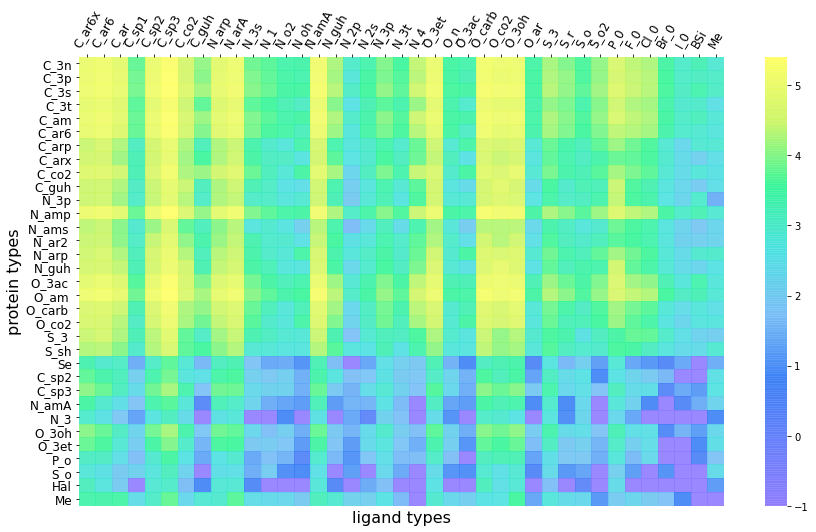

In [707]:
# we can visualize the contacts map
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def CustomCmap(cols):
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, col in enumerate(cols):
        if len(cdict['red']) == 0:
            cdict['red'].append((0, col[0], col[0]))
            cdict['green'].append((0, col[1], col[1]))
            cdict['blue'].append((0, col[2], col[2]))
        elif len(cdict['red']) == len(cols) - 1:
            cdict['red'].append((1, col[0], col[0]))
            cdict['green'].append((1, col[1], col[1]))
            cdict['blue'].append((1, col[2], col[2]))
        else:
            cdict['red'].append(((i+1)/len(cols), col[0], col[0]))
            cdict['green'].append(((i+1)/len(cols), col[1], col[1]))
            cdict['blue'].append(((i+1)/len(cols), col[2], col[2]))
    cdict['red'] = tuple(cdict['red'])
    cdict['green'] = tuple(cdict['green'])
    cdict['blue'] = tuple(cdict['blue'])

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

cmap1 = CustomCmap(np.array([[142, 123, 255], [59, 128, 245], [120, 190, 245], [75, 225, 225], [55, 245, 153], [204, 245, 102], [255, 255, 100]])/255,)
a = axes()
types_counts_loc = np.copy(np.sum(m_counts[:, :, :14], axis=2))
types_counts_loc[np.where(types_counts_loc == 0)] = 0.1
types_counts_loc = np.log10(types_counts_loc)
sns.heatmap(types_counts_loc, ax=a, cmap=cmap1,  linewidths=.0, alpha=0.9)
# a.set_aspect(1)
tick_label_fs = 12
a.set_xlabel('ligand types', fontsize=16)
a.set_ylabel('protein types', fontsize=16)
a.set_xticks([i + 0.5 for i in range(39)])
a.set_xticklabels(CPLAtomTypes.lig_types_[16])
a.set_yticks([i + 0.5 for i in range(33)])
a.set_yticklabels(CPLAtomTypes.prot_types_[5])
for tick in a.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_label_fs)
    tick.label.set_rotation(0)
a.xaxis.tick_top()
for tick in a.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_label_fs)
    tick.label.set_rotation(90)
xticks(rotation=60, fontsize=tick_label_fs)
fig = a.get_figure()
fig.set_size_inches(12.5, 7.5)
tight_layout()
show()

#### Smth else

In [45]:
found_cofactors = set()
for p in cf_info:
    for s in cf_info[p]:
        for ln in cf_info[p][s]:
            c0 = ln[0]
            c1 = ln[4]
#                 os.system('wget https://models.rcsb.org/v1/{0}/ligand?auth_seq_id={1}&'
#                 'label_asym_id={2}&encoding=mol2&filename={3}.mol2 -P {4}co_examples/'.format(p, ln[3], s, c0,
#                                                                                               PATH_main))
            
#                 os.system('wget https://models.rcsb.org/v1/{0}/ligand?auth_seq_id={1}&'
#                 'label_asym_id={2}&encoding=mol2&filename={3}.mol2 -P {4}co_examples/'.format(p, ln[7], s, c1,
#                                                                                               PATH_main))
            if c0 in cofactors_list:
                if c0 not in found_cofactors:
                    os.system('wget ftp://ftp.ebi.ac.uk/pub/databases/msd/pdbechem/files/pdb_r/{0}.pdb '
                              '-P {1}co_examples/'.format(c0, PATH_main))
                found_cofactors.add(c0)
            if c1 in cofactors_list:
                if c1 not in found_cofactors:
                    os.system('wget ftp://ftp.ebi.ac.uk/pub/databases/msd/pdbechem/files/pdb_r/{0}.pdb '
                              '-P {1}co_examples/'.format(c1, PATH_main))
                found_cofactors.add(c1)

print(len(found_cofactors))

182
